n: 1049
m: 2744
k_avg: 5.231649189704481
edge_length_total: 391503.96945491777
edge_length_avg: 142.67637370806042
streets_per_node_avg: 2.6873212583412776
streets_per_node_counts: {0: 0, 1: 312, 2: 26, 3: 458, 4: 212, 5: 25, 6: 8, 7: 7, 8: 0, 9: 0, 10: 0, 11: 1}
streets_per_node_proportions: {0: 0.0, 1: 0.2974261201143947, 2: 0.02478551000953289, 3: 0.43660629170638704, 4: 0.2020972354623451, 5: 0.023832221163012392, 6: 0.0076263107721639654, 7: 0.00667302192564347, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0009532888465204957}
intersection_count: 737
street_length_total: 199032.9657398293
street_segment_count: 1401
street_length_avg: 142.06492915048486
circuity_avg: 0.6292369973286189
self_loop_proportion: 0.004282655246252677
node_density_km: 8.23839508068198
intersection_density_km: 5.788081195865224
edge_density_km: 3074.70388562904
street_density_km: 1563.1193573351334


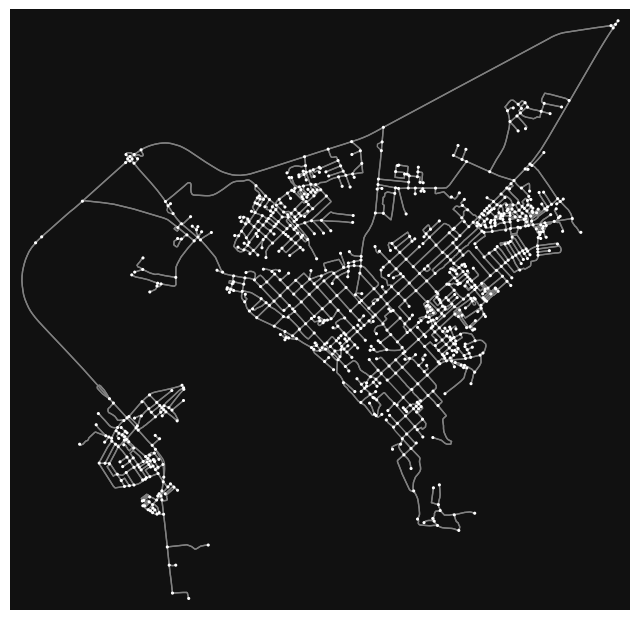

Центральность по степени:


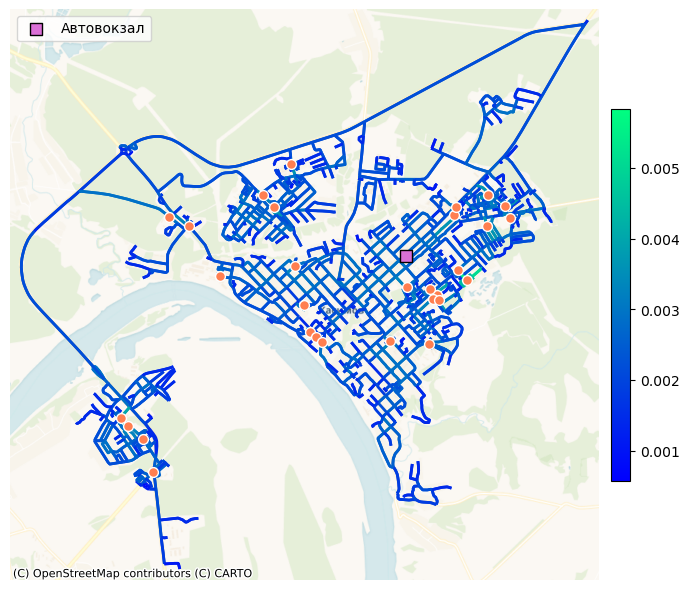

Центральность по близости:


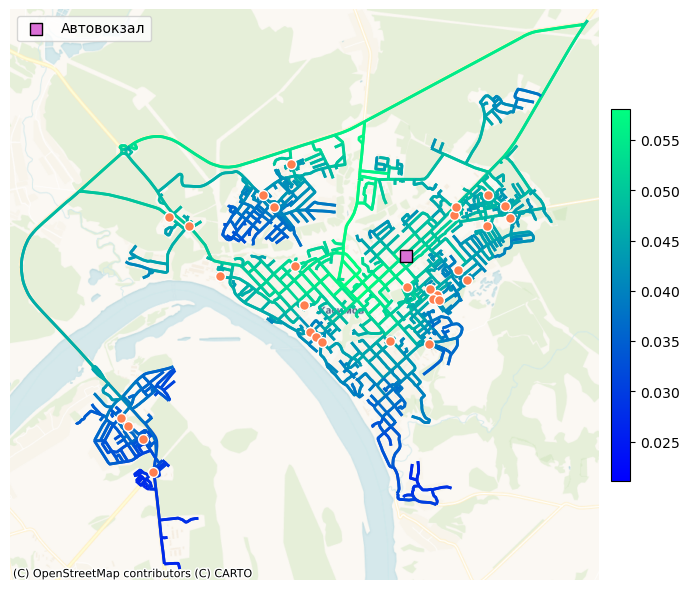


Метрики для вокзала:
Среднее время в пути: 7.4 мин
Макс. расстояние: 12.77 км (~25.5 мин)


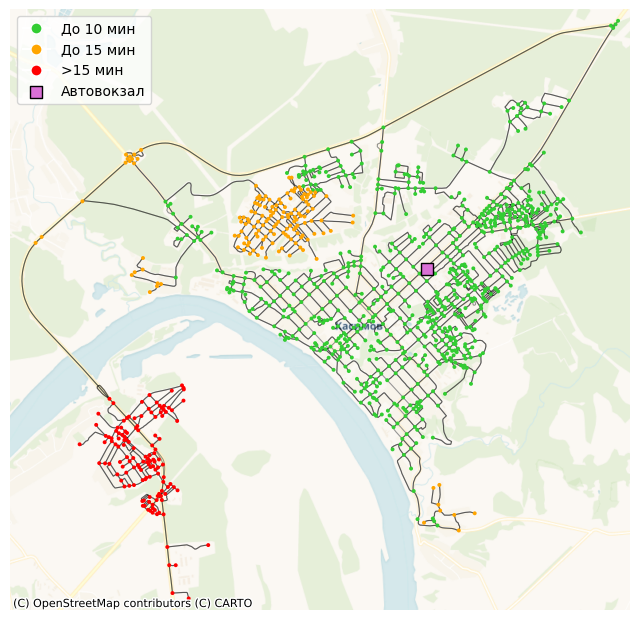

In [46]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
from matplotlib.lines import Line2D
from shapely.geometry import Point
from geopy.distance import geodesic
import os
import contextily as cx
import pyproj


save_dir = "kasimov_data"
os.makedirs(save_dir, exist_ok=True)

class CityStreetGraph:
    def __init__(self, city_name: str = None, network_type: str = "drive"):
        self.city_name = city_name
        self.network_type = network_type
        self.graph = None              # Географический (WGS84, градусы)
        self.graph_proj = None         # Проектированный (метры), для консолидации и метрик
        self.highlighted_nodes = set()

    # ---------- Загрузка ----------
    def load_graph_by_place(self):
        if not self.city_name:
            raise ValueError("Название города не указано.")
        self.graph = ox.graph_from_place(self.city_name, network_type=self.network_type, simplify=True)
        self.graph_proj = None  # сбрасываем проектированную версию, т.к. граф обновился

    def load_graph_by_point(self, lat: float, lon: float, distance: int = 3000):
        self.graph = ox.graph_from_point((lat, lon), dist=distance, network_type=self.network_type, simplify=True)
        self.graph_proj = None  # сброс

    # ---------- Проекция и консолидация ----------
    def project_graph(self, to_crs="EPSG:3857"):
        """
        Проецирует граф: если to_crs=None — в подходящую метрическую проекцию (обычно UTM).
        Результат кладётся в self.graph_proj.
        """
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        self.graph_proj = ox.project_graph(self.graph, to_crs=to_crs)

    def consolidate_intersections(self, tolerance: float = 15, dead_ends: bool = True):
        """
        Объединяет близко расположенные узлы перекрёстков (в метрах).
        Работает ТОЛЬКО на проектированном графе.
        После консолидации обновляет обе версии графа: graph_proj и graph (WGS84).
        Параметр tolerance ~ 10–25 м обычно даёт хороший результат.
        """
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        if self.graph_proj is None:
            # гарантируем проектирование
            self.project_graph()

        # В разных версиях osmnx возвращаемое значение может отличаться
        res = ox.simplification.consolidate_intersections(
            self.graph_proj, tolerance=tolerance, dead_ends=dead_ends
        )
        Gc = res[0] if isinstance(res, tuple) else res

        # сохраняем проектированный граф после консолидации
        self.graph_proj = Gc
        # и обновляем географический граф, чтобы все остальные функции работали как раньше
        self.graph = ox.project_graph(self.graph_proj, to_crs="EPSG:4326")

    # ---------- Инфо ----------
    def show_basic_info(self):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        stats = ox.basic_stats(self.graph)
        for k, v in stats.items():
            print(f"{k}: {v}")

    def show_basic_info_extended(self):
        """
        Расширенная статистика по площади выпуклой оболочки ребер.
        Использует проектированную версию графа (если нет — создаёт).
        """
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        if self.graph_proj is None:
            self.project_graph()

        edges = ox.graph_to_gdfs(self.graph_proj, nodes=False, edges=True)
        convex_hull = edges.geometry.union_all().convex_hull
        stats = ox.basic_stats(self.graph_proj, area=convex_hull.area)
        for k, v in stats.items():
            print(f"{k}: {v}")

    # ---------- Визуализация ----------
    def draw_graph(self, save_path: str = None):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        fig, ax = ox.plot_graph(self.graph, node_size=5, edge_color='gray')
        if save_path:
            fig.savefig(save_path, dpi=300)
            print(f"Граф сохранён в файл: {save_path}")
        else:
            plt.show()

    def draw_graph_with_highlights(self):
        fig, ax = ox.plot_graph(self.graph, node_size=5, edge_color="gray", show=False, close=False)
        if self.highlighted_nodes:
            gdf_nodes = ox.graph_to_gdfs(self.graph, edges=False)
            highlighted = gdf_nodes.loc[list(self.highlighted_nodes)]
            ax.scatter(highlighted.geometry.x, highlighted.geometry.y, s=30, c='red', edgecolors='white', zorder=5)
        plt.show()

    # ---------- Сохранение/загрузка ----------
    def save_graphml(self, filename: str = "kasimov.graphml"):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        filepath = os.path.join(save_dir, filename)
        ox.save_graphml(self.graph, filepath)

    def load_graphml(self, filename: str = "kasimov.graphml"):
        filepath = os.path.join(save_dir, filename)
        self.graph = ox.load_graphml(filepath)
        self.graph_proj = None  # сбрасываем: при необходимости пересчитаем

    # ---------- Утилиты ----------
    def highlight_nodes_near_locations(self, locations: list[tuple[float, float, float]]):
        """
        Подсвечивает узлы в радиусе radius_m от (lat, lon).
        """
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        self.highlighted_nodes.clear()
        for lat, lon, radius in locations:
            for node_id, data in self.graph.nodes(data=True):
                dist = geodesic((lat, lon), (data['y'], data['x'])).meters
                if dist <= radius:
                    self.highlighted_nodes.add(node_id)
        self.draw_graph_with_highlights()

    def remove_highlighted_nodes(self, save_filename: str = None):
        """
        Удаляет подсвеченные узлы из обеих версий графа (если proj существует),
        чтобы они не «рассинхронизировались».
        """
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        # удаляем из географического графа
        self.graph.remove_nodes_from(self.highlighted_nodes)
        # удаляем из проектированного, если он уже построен
        if self.graph_proj is not None:
            existing = [n for n in self.highlighted_nodes if n in self.graph_proj.nodes]
            self.graph_proj.remove_nodes_from(existing)

        self.highlighted_nodes.clear()

        if save_filename:
            filepath = os.path.join(save_dir, save_filename)
            ox.save_graphml(self.graph, filepath)

    def add_node(self, lat: float, lon: float):
        if self.graph is None:
            raise ValueError("Граф ещё не загружен.")
        new_node_id = max(self.graph.nodes) + 1
        self.graph.add_node(new_node_id, x=lon, y=lat)

        nearest = ox.distance.nearest_nodes(self.graph, X=lon, Y=lat)
        distance = ox.distance.great_circle_vec(lat, lon, self.graph.nodes[nearest]['y'], self.graph.nodes[nearest]['x'])
        self.graph.add_edge(new_node_id, nearest, length=distance)
        self.graph.add_edge(nearest, new_node_id, length=distance)

        print(f"Добавлен узел {new_node_id}, соединён с узлом {nearest}.")
        fig, ax = ox.plot_graph(self.graph, node_size=5, edge_color="gray", show=False, close=False)
        ax.scatter(lon, lat, s=60, c='lime', edgecolors='black', zorder=5)
        plt.show()

    def find_centralities(self):
        line_G = nx.line_graph(self.graph)
        print("Центральность по степени:")
        edge_centrality = nx.degree_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

        print("Центральность по близости:")
        edge_centrality = nx.closeness_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

    def show_centrality_heatmap(self, edge_centrality, highlight_top_nodes=True):
        if self.graph_proj is None:
            self.project_graph()
        ev = []
        for edge in self.graph_proj.edges(keys=False):
            edge_key = edge + (0,)
            val = edge_centrality.get(edge_key, 0)
            ev.append(val)

        norm = colors.Normalize(vmin=min(ev) * 0.8, vmax=max(ev))
        cmap = cm.ScalarMappable(norm=norm, cmap=cm.winter)
        ec = [cmap.to_rgba(val) for val in ev]

        fig, ax = ox.plot_graph(
            self.graph_proj,
            bgcolor='black',
            node_size=0,
            edge_color=ec,
            edge_linewidth=2,
            edge_alpha=1,
            show=False,
            close=False
        )

        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs='EPSG:3857')

        if highlight_top_nodes:
            node_centrality = nx.degree_centrality(self.graph_proj)
            top_nodes = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)[:30]
            gdf_nodes = ox.graph_to_gdfs(self.graph_proj, edges=False)
            for node_id, score in top_nodes:
                geom = gdf_nodes.loc[node_id].geometry
                ax.scatter(geom.x, geom.y, s=50, c='coral', edgecolors='white', zorder=5)

        cbar = plt.colorbar(cmap, ax=ax, fraction=0.03, pad=0.02)
        cbar.ax.yaxis.set_tick_params(color='black')

        # Координаты автовокзала
        bus_station_lat = 54.946817
        bus_station_lon = 41.409804

        # Трансформер для перевода в проекцию графа
        proj = pyproj.Transformer.from_crs("EPSG:4326", self.graph_proj.graph['crs'], always_xy=True)
        bus_x, bus_y = proj.transform(bus_station_lon, bus_station_lat)

        # После построения графа и до plt.show():
        ax.scatter(bus_x, bus_y, marker='s', s=80, color='orchid', edgecolor='black', label='Автовокзал')
        ax.legend(loc='upper left')

        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
        ax.set_axis_off()
        plt.show()
        fig.savefig(os.path.join(save_dir, "centrality_heatmap.png"), dpi=300)
        plt.close()


    def analyze_station_metrics(self, station_coords, speed_kmh=30):
        if self.graph_proj is None:
            self.project_graph()
        print("\nМетрики для вокзала:")
        # Переводим координаты станции в проекцию
        import pyproj
        proj = pyproj.Transformer.from_crs("EPSG:4326", self.graph_proj.graph['crs'], always_xy=True)
        x, y = proj.transform(station_coords[1], station_coords[0])
        station_node = ox.distance.nearest_nodes(self.graph_proj, X=x, Y=y)

        lengths = nx.single_source_dijkstra_path_length(self.graph_proj, station_node, weight="length")
        avg_distance_m = np.mean(list(lengths.values()))
        avg_time_min = avg_distance_m / (speed_kmh * 1000 / 60)
        print(f"Среднее время в пути: {avg_time_min:.1f} мин")

        time_10_m = (10 / 60) * speed_kmh * 1000
        time_15_m = (15 / 60) * speed_kmh * 1000

        reachable_10 = [n for n, d in lengths.items() if d <= time_10_m]
        reachable_15 = [n for n, d in lengths.items() if d <= time_15_m]

        max_dist = max(lengths.values()) if lengths else 0
        print(f"Макс. расстояние: {max_dist/1000:.2f} км (~{max_dist/(speed_kmh * 1000 / 60):.1f} мин)")

        node_colors = []
        for node in self.graph_proj.nodes:
            if node in reachable_10:
                node_colors.append("limegreen")
            elif node in reachable_15:
                node_colors.append("orange")
            else:
                node_colors.append("red")

        fig, ax = ox.plot_graph(
            self.graph_proj,
            node_color=node_colors,
            node_size=8,
            edge_color="black",
            edge_linewidth=0.8,
            edge_alpha=0.4,
            bgcolor="white",
            show=False,
            close=False
        )

        # Координаты автовокзала
        bus_station_lat = 54.946817
        bus_station_lon = 41.409804

        # Трансформер для перевода в проекцию графа
        proj = pyproj.Transformer.from_crs("EPSG:4326", self.graph_proj.graph['crs'], always_xy=True)
        bus_x, bus_y = proj.transform(bus_station_lon, bus_station_lat)
        ax.scatter(bus_x, bus_y, marker='s', s=80, color='orchid', edgecolor='black', label='Автовокзал')

        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs='EPSG:3857')

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='До 10 мин', markerfacecolor='limegreen', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='До 15 мин', markerfacecolor='orange', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='>15 мин', markerfacecolor='red', markersize=8),
        ]
        star_proxy = plt.scatter([], [], marker='s', s=80, color='orchid', edgecolor='black', label='Автовокзал')
        # Добавляем proxy-artist к списку
        legend_elements.append(star_proxy)
        ax.legend(handles=legend_elements, loc='upper left')
        ax.set_axis_off()
        plt.show()
        fig.savefig(os.path.join(save_dir, "station_metrics.png"), dpi=300)
        plt.close()


    def find_bottlenecks(self, top_k=50):
        print("\nПоиск транспортных проблем:")
        simple_graph = nx.DiGraph()
        for u, v, data in self.graph.edges(data=True):
            length = data.get("length", 1)
            if simple_graph.has_edge(u, v):
                simple_graph[u][v]["length"] = min(simple_graph[u][v]["length"], length)
            else:
                simple_graph.add_edge(u, v, length=length)

        edge_betweenness = nx.edge_betweenness_centrality(simple_graph, weight="length")

        edge_scores = []
        for u, v, k in self.graph.edges(keys=True):
            edge = (u, v, k)
            btwn = edge_betweenness.get((u, v), 0) or edge_betweenness.get((v, u), 0)
            length = self.graph[u][v][k].get("length", 1)
            deg_u = self.graph.degree(u)
            deg_v = self.graph.degree(v)
            min_deg = min(deg_u, deg_v)
            score = (btwn / length) * (1 / (min_deg + 0.1))
            edge_scores.append((edge, score, btwn, length, min_deg))

        edge_scores.sort(key=lambda x: x[1], reverse=True)
        worst_edges = [edge for edge, *_ in edge_scores[:top_k]]

        edge_colors = []
        for edge in self.graph.edges(keys=True):
            edge_colors.append("red" if edge in worst_edges else "gray")

        fig, ax = ox.plot_graph(
            self.graph,
            edge_color=edge_colors,
            edge_linewidth=2.8,
            node_size=0,
            edge_alpha=0.9,
            bgcolor="white",
            show=False,
            close=False
        )
        plt.show()

        print("Топ проблемных участков:")
        for i, (edge, score, btwn, length, min_deg) in enumerate(edge_scores[:top_k]):
            u, v, k = edge
            street_name = self.graph[u][v][k].get("name", "Без названия")
            print(
                f"{i+1}. {street_name} ({u} → {v}) | Score: {score:.4f} | "
                f"Betweenness: {btwn:.5f} | Длина: {length:.1f} м | Мин. степень: {min_deg}"
            )


kasimov = CityStreetGraph(network_type="drive_service")

"""latitude = 54.937289
longitude = 41.391369
kasimov.load_graph_by_point(lat=latitude, lon=longitude, distance=4500)"""

kasimov.load_graphml("kasimov_new_drive_service_cleaned.graphml")

kasimov.project_graph()
"""kasimov.consolidate_intersections(tolerance=15, dead_ends=True)

kasimov.draw_graph()

regions = [
    (54.906673, 41.334081, 1000),
    (54.956080, 41.325784, 590),
    (54.949464, 41.330700, 100),
    (54.977284, 41.323257, 1000),
    (54.973779, 41.395870, 500),
    (54.907629, 41.420843, 800),
    (54.899666, 41.448738, 200),
    (54.917667, 41.457063, 900),
    (54.940375, 41.436705, 100),
    (54.922928, 41.325043, 500),
    (54.929697, 41.339923, 50),
    (54.928493, 41.337322, 20),
    (54.940244, 41.355633, 200),
    (54.939203, 41.350953, 100),
    (54.933768, 41.345219, 400),
    (54.935473, 41.349387, 80),
    (54.950449, 41.325361, 40),
    (54.967265, 41.396800, 350),
    (54.939319, 41.432232, 550),
    (54.935149, 41.379052, 10)
]
kasimov.highlight_nodes_near_locations(regions)
kasimov.remove_highlighted_nodes(save_filename="kasimov_new_drive_service_cleaned.graphml")"""

kasimov.show_basic_info_extended()
kasimov.draw_graph()
kasimov.find_centralities()
kasimov.analyze_station_metrics(station_coords=(54.946817, 41.409804))
# kasimov.analyze_station_metrics(station_coords=(54.954630, 41.422359))


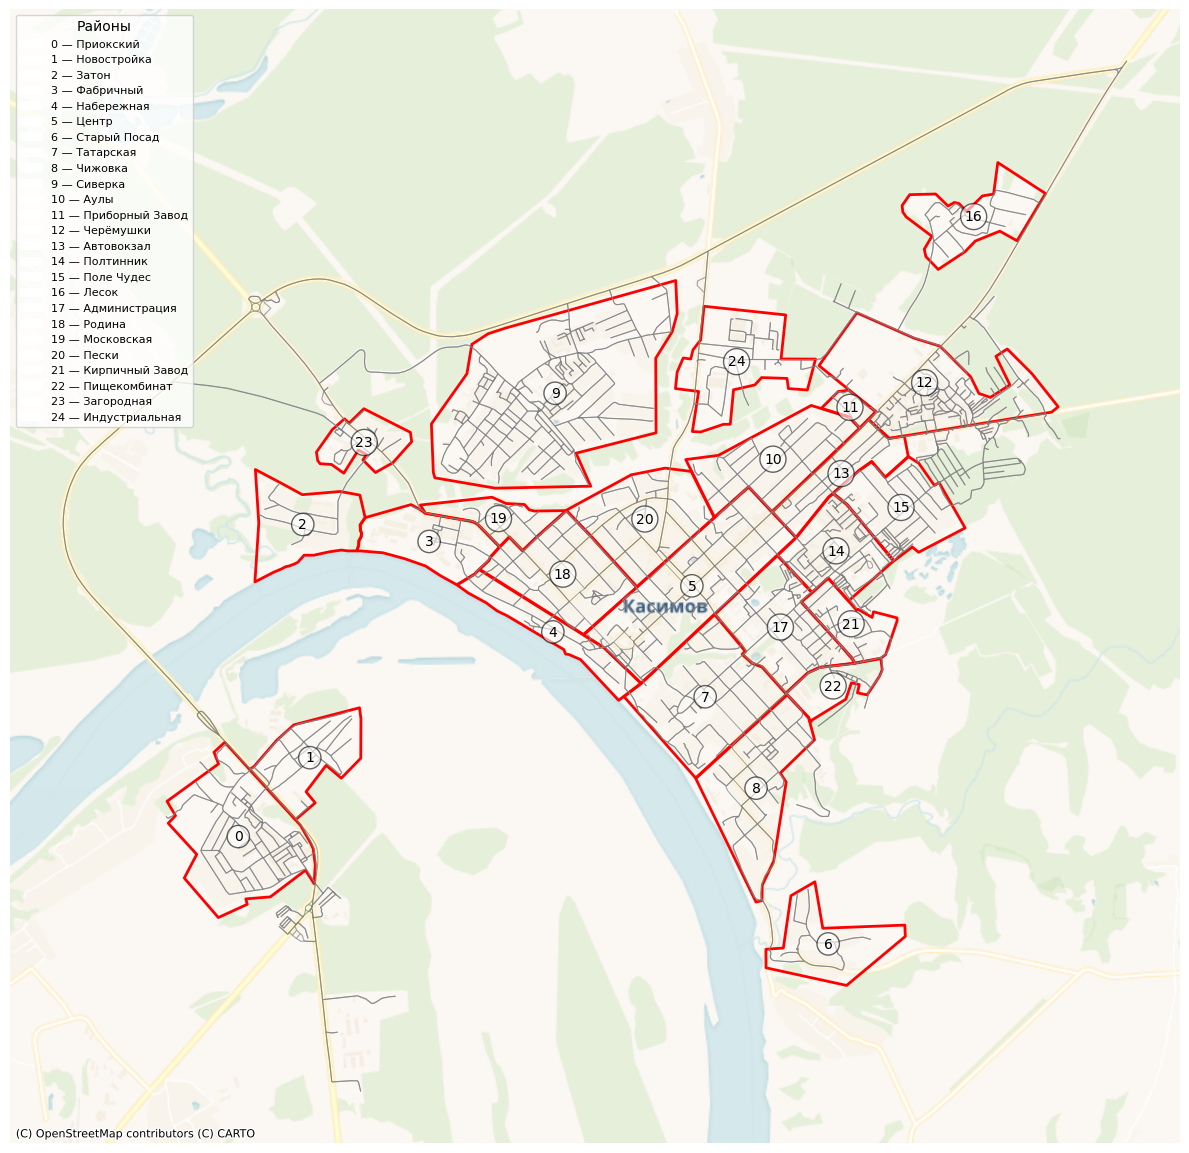

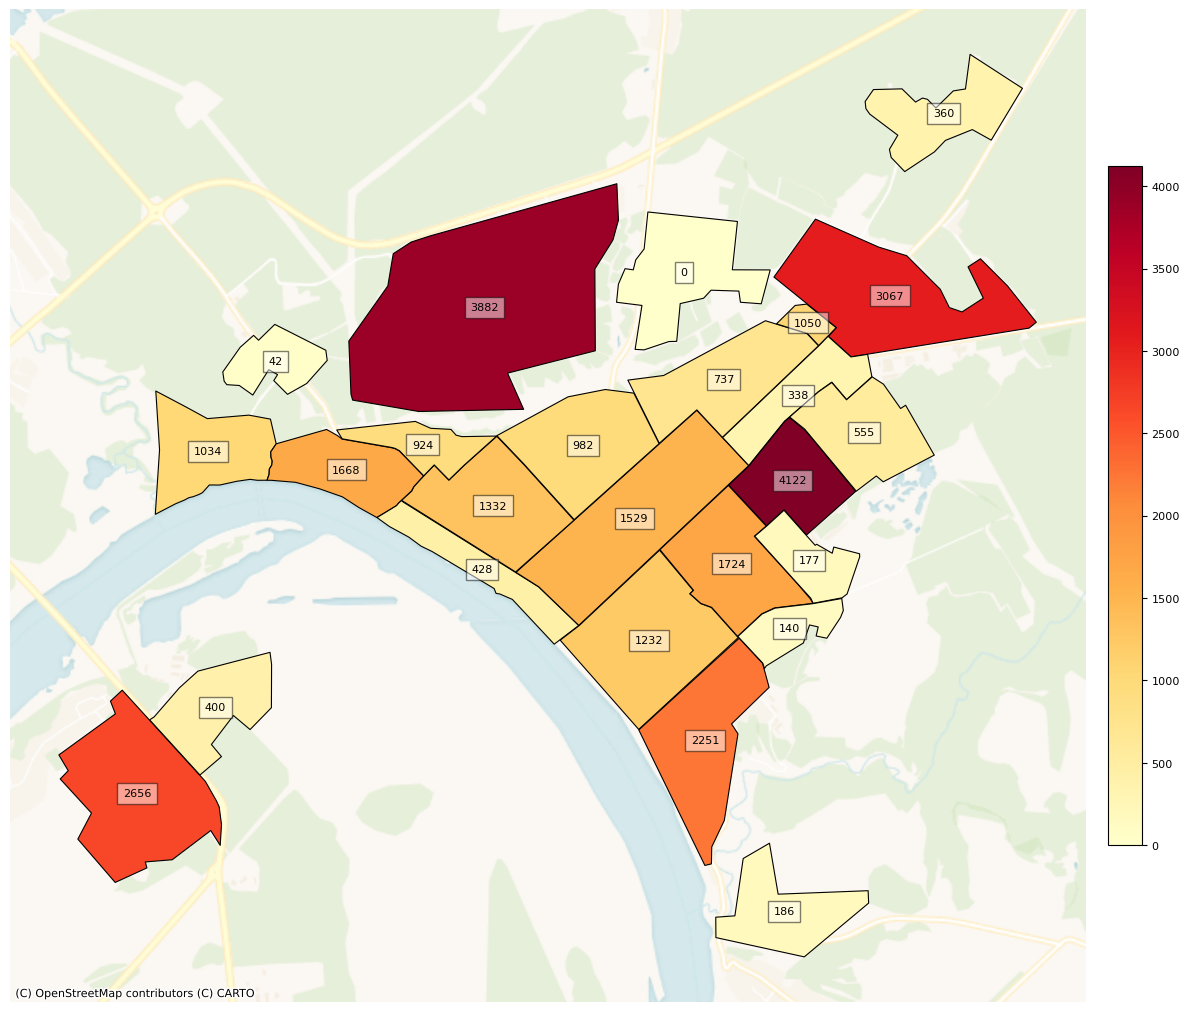

In [47]:
import geopandas as gpd
import pandas as pd
import matplotlib.patches as mpatches

# Данные по домам
"""
в словаре для каждого района сопоставлен список из количества разного типа домов:
нулевыми в списке идут - private_houses
первыми - one_storey_houses
вторыми - two_storey_houses
третьими - three_storey_houses
четвертыми - four_storey_houses
пятыми - five_storey_houses
"""
zones_population = {
    0: [128, 0, 0, 0, 0, 16],
    1: [125, 0, 5, 0, 0, 0],
    2: [52, 0, 5, 4, 0, 4],
    3: [24, 0, 14, 6, 5, 3],
    4: [64, 3, 6, 2, 0, 0],
    5: [292, 0, 4, 5, 0, 4],
    6: [93, 0, 0, 0, 0, 0],
    7: [331, 0, 9, 0, 0, 2],
    8: [302, 0, 1, 15, 2, 5],
    9: [492, 0, 13, 26, 3, 7],
    10: [346, 0, 0, 1, 0, 0],
    11: [0, 0, 0, 0, 0, 7],
    12: [38, 0, 54, 5, 1, 7],
    13: [169, 0, 0, 0, 0, 0],
    14: [21, 0, 1, 0, 0, 27],
    15: [210, 0, 0, 3, 0, 0],
    16: [75, 0, 1, 4, 0, 0],
    17: [202, 0, 1, 2, 0, 8],
    18: [393, 0, 3, 8, 1, 0],
    19: [107, 2, 0, 2, 0, 4],
    20: [371, 0, 5, 2, 0, 0],
    21: [36, 0, 2, 1, 0, 0],
    22: [25, 0, 3, 0, 0, 0],
    23: [21, 0, 0, 0, 0, 0],
    24: [0, 0, 0, 0, 0, 0],
}

# Коэффициенты: сколько человек живёт в доме данного типа
household_coeffs = {
    "private": 2,
    "one_storey": 10,
    "two_storey": 30,
    "three_storey": 45,
    "four_storey": 96,
    "five_storey": 150,
}


class TransportZoning:
    def __init__(self, city_graph: nx.MultiDiGraph, geojson_path: str):
        self.graph = city_graph
        self.geojson_path = geojson_path
        self.zone_assignments = {}  # node_id -> zone_id
        self.gdf_districts = None  # GeoDataFrame зон

    def load_real_zones(self):
        """Загрузка реальных границ из GeoJSON"""
        districts = gpd.read_file(self.geojson_path)

        # CRS
        if districts.crs is None:
            districts.set_crs(epsg=4326, inplace=True)
        elif districts.crs.to_epsg() != 4326:
            districts = districts.to_crs(epsg=4326)

        # zone_id и zone_name
        districts = districts.reset_index(drop=True)
        districts["zone_id"] = districts.index
        if "name" not in districts.columns:
            districts["zone_name"] = [f"Зона {i}" for i in range(len(districts))]
        else:
            districts.rename(columns={"name": "zone_name"}, inplace=True)

        self.gdf_districts = districts

    def rename_zones(self, mapping: dict):
        """Переименовать районы"""
        if self.gdf_districts is None:
            raise ValueError("Сначала вызовите load_real_zones()")
        self.gdf_districts["zone_name"] = self.gdf_districts["zone_name"].replace(mapping)

    def assign_nodes_to_zones(self):
        """Присвоить узлы графа районам"""
        if self.gdf_districts is None:
            raise ValueError("Сначала вызовите load_real_zones()")

        nodes_data = [
            (nid, data["x"], data["y"])
            for nid, data in self.graph.nodes(data=True)
        ]
        df_nodes = pd.DataFrame(nodes_data, columns=["node_id", "x", "y"])
        gdf_nodes = gpd.GeoDataFrame(
            df_nodes, geometry=gpd.points_from_xy(df_nodes.x, df_nodes.y), crs="EPSG:4326"
        )

        joined = gpd.sjoin(gdf_nodes, self.gdf_districts, how="left", predicate="within")

        for row in joined.itertuples():
            zone_id = int(row.zone_id) if pd.notnull(row.zone_id) else None
            self.graph.nodes[row.node_id]["zone"] = zone_id
            if zone_id is not None:
                self.zone_assignments[row.node_id] = zone_id

    def calculate_population_from_houses(self, zones_population: dict, coeffs: dict):
        """Подсчёт населения в каждом районе на основе домов"""
        populations = {}
        for zone_id, houses in zones_population.items():
            pop = (
                houses[0] * coeffs["private"]
                + houses[1] * coeffs["one_storey"]
                + houses[2] * coeffs["two_storey"]
                + houses[3] * coeffs["three_storey"]
                + houses[4] * coeffs["four_storey"]
                + houses[5] * coeffs["five_storey"]
            )
            populations[zone_id] = pop

        # Добавляем в GeoDataFrame
        self.gdf_districts["population"] = self.gdf_districts["zone_id"].map(populations)

    def visualize_zones_with_numbers(self):
        """Визуализация с номерами районов"""
        if self.gdf_districts is None:
            raise ValueError("Нет загруженных границ зон")

        districts_web = self.gdf_districts.to_crs(epsg=3857)
        gdf_edges = ox.graph_to_gdfs(self.graph, nodes=False, edges=True).to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(12, 12))

        districts_web.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

        for row in districts_web.itertuples():
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, str(row.zone_id),
                    fontsize=10, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, boxstyle="circle"))

        gdf_edges.plot(ax=ax, linewidth=0.8, color="gray", alpha=0.7)
        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

        legend_labels = [f"{row.zone_id} — {row.zone_name}" for row in districts_web.itertuples()]
        patches = [mpatches.Patch(color="white", label=lbl) for lbl in legend_labels]
        ax.legend(handles=patches, loc="upper left", fontsize=8, frameon=True, title="Районы")

        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

    def visualize_population_heatmap(self):
        """Тепловая карта населения по районам"""
        if "population" not in self.gdf_districts.columns:
            raise ValueError("Сначала вызовите calculate_population_from_houses()")

        districts_web = self.gdf_districts.to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(12, 12))

        # Задаем colormap и значения
        cmap = plt.cm.YlOrRd
        norm = colors.Normalize(
            vmin=districts_web["population"].min(),
            vmax=districts_web["population"].max()
        )

        # Рисуем районы с нормализацией
        districts_web.plot(
            ax=ax,
            column="population",
            cmap=cmap,
            linewidth=0.8,
            edgecolor="black"
        )

        # Подложка
        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

        # Подписи численности
        for row in districts_web.itertuples():
            centroid = row.geometry.centroid
            ax.text(
                centroid.x, centroid.y,
                str(int(row.population)),
                fontsize=8, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.5)
            )

        # Цветовая шкала
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []  # костыль для matplotlib
        cbar = fig.colorbar(sm, ax=ax, shrink=0.7, fraction=0.03, pad=0.02)
        cbar.ax.yaxis.set_tick_params(color='black')
        plt.setp(cbar.ax.get_yticklabels(), color='black', fontsize=8)

        # ax.set_title("Тепловая карта населения по районам", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

# --- Использование ---
geojson_path = "kasimov_data/map.geojson"
zoning = TransportZoning(kasimov.graph, geojson_path)

zoning.load_real_zones()

rename_map = {
    "Зона 0": "Приокский",
    "Зона 1": "Новостройка",
    "Зона 2": "Затон",
    "Зона 3": "Фабричный",
    "Зона 4": "Набережная",
    "Зона 5": "Центр",
    "Зона 6": "Старый Посад",
    "Зона 7": "Татарская",
    "Зона 8": "Чижовка",
    "Зона 9": "Сиверка",
    "Зона 10": "Аулы",
    "Зона 11": "Приборный Завод",
    "Зона 12": "Черёмушки",
    "Зона 13": "Автовокзал",
    "Зона 14": "Полтинник",
    "Зона 15": "Поле Чудес",
    "Зона 16": "Лесок",
    "Зона 17": "Администрация",
    "Зона 18": "Родина",
    "Зона 19": "Московская",
    "Зона 20": "Пески",
    "Зона 21": "Кирпичный Завод",
    "Зона 22": "Пищекомбинат",
    "Зона 23": "Загородная",
    "Зона 24": "Индустриальная",
}
zoning.rename_zones(rename_map)

zoning.assign_nodes_to_zones()
zoning.calculate_population_from_houses(zones_population, household_coeffs)

# Визуализации
zoning.visualize_zones_with_numbers()
zoning.visualize_population_heatmap()

In [48]:
# Загружаем районы
districts = zoning.gdf_districts.copy()

# Примерные коэффициенты проживающих по этажности
coeffs = {
    "private": 2,
    "one_storey": 10,
    "two_storey": 30,
    "three_storey": 45,
    "four_storey": 96,
    "five_storey": 150
}

# Таблица домов по районам (из твоего словаря)
zones_population = {
    0: [128, 0, 0, 0, 0, 16],
    1: [125, 0, 5, 0, 0, 0],
    2: [52, 0, 5, 4, 0, 4],
    3: [24, 0, 14, 6, 5, 3],
    4: [64, 3, 6, 2, 0, 0],
    5: [292, 0, 4, 5, 0, 4],
    6: [93, 0, 0, 0, 0, 0],
    7: [331, 0, 9, 0, 0, 2],
    8: [302, 0, 1, 15, 2, 5],
    9: [492, 0, 13, 26, 3, 7],
    10: [346, 0, 0, 1, 0, 0],
    11: [0, 0, 0, 0, 0, 7],
    12: [38, 0, 54, 5, 1, 7],
    13: [169, 0, 0, 0, 0, 0],
    14: [21, 0, 1, 0, 0, 27],
    15: [210, 0, 0, 3, 0, 0],
    16: [75, 0, 1, 4, 0, 0],
    17: [202, 0, 1, 2, 0, 8],
    18: [393, 0, 3, 8, 1, 0],
    19: [107, 2, 0, 2, 0, 4],
    20: [371, 0, 5, 2, 0, 0],
    21: [36, 0, 2, 1, 0, 0],
    22: [25, 0, 3, 0, 0, 0],
    23: [21, 0, 0, 0, 0, 0],
    24: [0, 0, 0, 0, 0, 0],
}

# Вычисляем население
population = {}
for zone_id, houses in zones_population.items():
    total = (
        houses[0] * coeffs["private"] +
        houses[1] * coeffs["one_storey"] +
        houses[2] * coeffs["two_storey"] +
        houses[3] * coeffs["three_storey"] +
        houses[4] * coeffs["four_storey"] +
        houses[5] * coeffs["five_storey"]
    )
    population[zone_id] = total

# Добавляем в GeoDataFrame
districts["population"] = districts["zone_id"].map(population)

# Центроиды для Kepler
districts["lon"] = districts.centroid.x
districts["lat"] = districts.centroid.y

# Итоговая таблица
df_kepler = districts[["zone_id", "zone_name", "lon", "lat", "population"]]
df_kepler.to_csv("kasimov_data/kasimov_population_kepler.csv", index=False)

/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3752831321.py:60: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts["lon"] = districts.centroid.x
/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3752831321.py:61: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts["lat"] = districts.centroid.y


In [49]:
import geopandas as gpd
import json

# Загрузим границы
gdf = gpd.read_file("kasimov_data/map.geojson")

# Словарь домов по районам
zones_population = {
    0: [128, 0, 0, 0, 0, 16],
    1: [125, 0, 5, 0, 0, 0],
    2: [52, 0, 5, 4, 0, 4],
    3: [24, 0, 14, 6, 5, 3],
    4: [64, 3, 6, 2, 0, 0],
    5: [292, 0, 4, 5, 0, 4],
    6: [93, 0, 0, 0, 0, 0],
    7: [331, 0, 9, 0, 0, 2],
    8: [302, 0, 1, 15, 2, 5],
    9: [492, 0, 13, 26, 3, 7],
    10: [346, 0, 0, 1, 0, 0],
    11: [0, 0, 0, 0, 0, 7],
    12: [38, 0, 54, 5, 1, 7],
    13: [169, 0, 0, 0, 0, 0],
    14: [21, 0, 1, 0, 0, 27],
    15: [210, 0, 0, 3, 0, 0],
    16: [75, 0, 1, 4, 0, 0],
    17: [202, 0, 1, 2, 0, 8],
    18: [393, 0, 3, 8, 1, 0],
    19: [107, 2, 0, 2, 0, 4],
    20: [371, 0, 5, 2, 0, 0],
    21: [36, 0, 2, 1, 0, 0],
    22: [25, 0, 3, 0, 0, 0],
    23: [21, 0, 0, 0, 0, 0],
    24: [0, 0, 0, 0, 0, 0],
}

# Коэффициенты: [частный, 1 эт, 2 эт, 3 эт, 4 эт, 5 эт]
coeffs = [2, 10, 30, 45, 96, 150]

# Вычисляем население
zone_pop = {z: sum(h * c for h, c in zip(houses, coeffs))
            for z, houses in zones_population.items()}

# Добавляем в GeoDataFrame
gdf["population"] = gdf.index.map(zone_pop)

# Сохраняем новый GeoJSON
gdf.to_file("kasimov_data/zones_with_population.geojson", driver="GeoJSON")

/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3600961220.py:97: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poi_gdf["geometry"] = poi_gdf.geometry.centroid


Загружено POI объектов: 194
Зона 0: Аттракторов — 17
Зона 1: Аттракторов — 4
Зона 2: Аттракторов — 0
Зона 3: Аттракторов — 6
Зона 4: Аттракторов — 8
Зона 5: Аттракторов — 48
Зона 6: Аттракторов — 1
Зона 7: Аттракторов — 8
Зона 8: Аттракторов — 6
Зона 9: Аттракторов — 2
Зона 10: Аттракторов — 0
Зона 11: Аттракторов — 1
Зона 12: Аттракторов — 14
Зона 13: Аттракторов — 10
Зона 14: Аттракторов — 7
Зона 15: Аттракторов — 4
Зона 16: Аттракторов — 0
Зона 17: Аттракторов — 15
Зона 18: Аттракторов — 8
Зона 19: Аттракторов — 1
Зона 20: Аттракторов — 3
Зона 21: Аттракторов — 1
Зона 22: Аттракторов — 1
Зона 23: Аттракторов — 7
Зона 24: Аттракторов — 5

--- Зона 0 (Приокский) ---
  Аттракторы:
    - Сбербанк (bank)
    - Почтовое отделение (post_office)
    - СОШ № 6 им. адмирала Авинова (school)
    - nan (parking)
    - nan (nan)
    - nan (pharmacy)
    - nan (nan)
    - nan (school)
    - nan (nan)
    - nan (nan)
    - nan (school)
    - nan (nan)
    - nan (school)
    - nan (kindergarten)
  

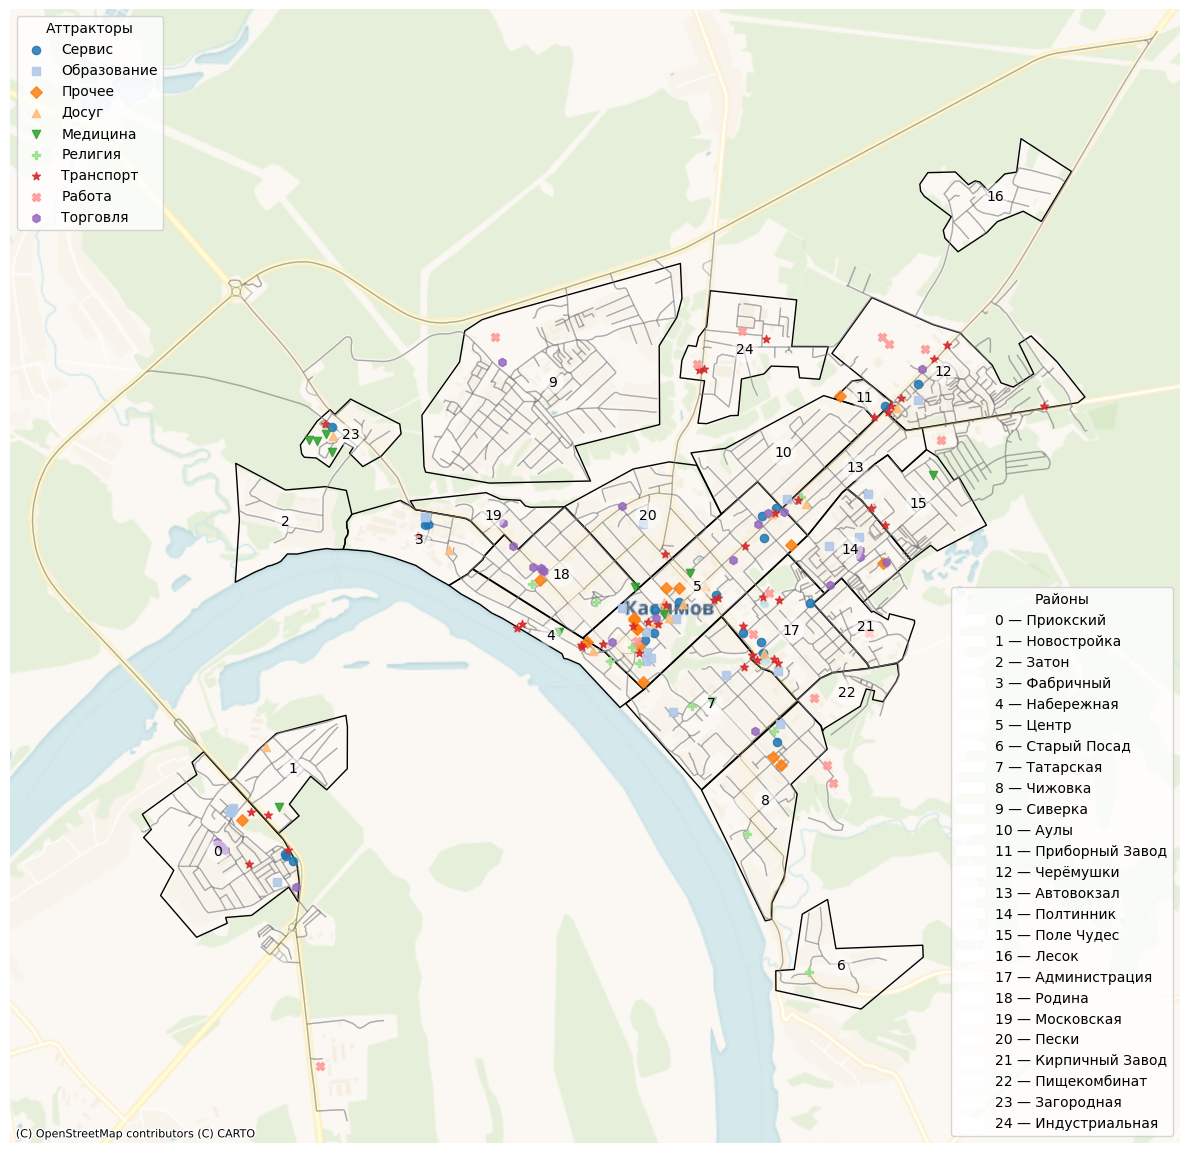

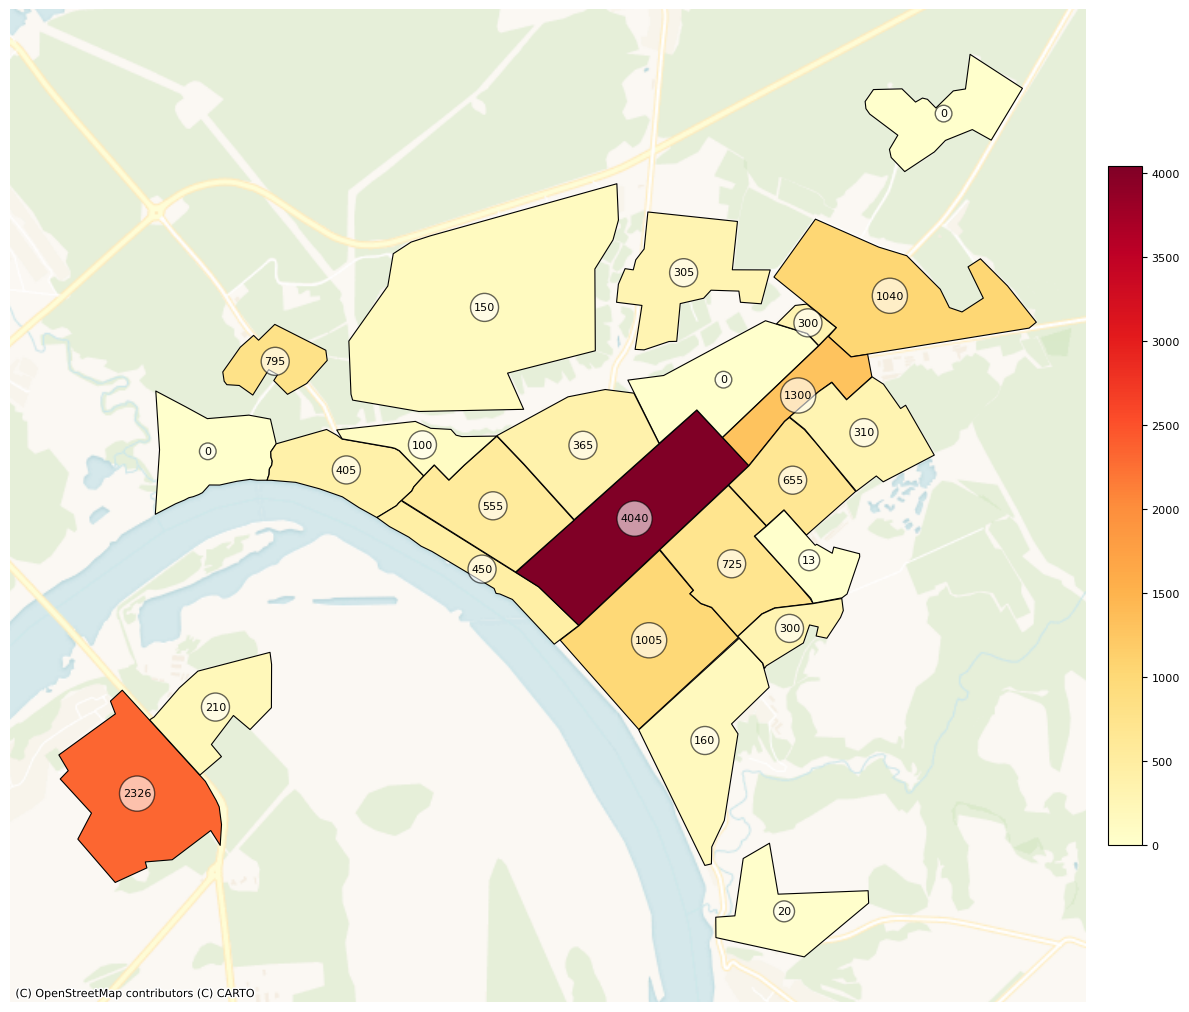

In [50]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from shapely.geometry import Point

class TripModel:
    def __init__(self, zoning):
        self.zoning = zoning
        self.graph = zoning.graph
        self.population = {}      # население по зонам
        self.attractors = {}      # POI по зонам
        self.production = {}      # генерация (production)
        self.attraction = {}      # притяжение (attraction)
        self.df_trips = None
        self.poi_gdf = None

        # Инициализация словарей по всем зонам
        for zone_id in zoning.gdf_districts.index:
            self.population[zone_id] = {}
            self.attractors[zone_id] = []
            self.production[zone_id] = 0
            self.attraction[zone_id] = 0

    # -----------------
    #   ВСПОМОГАТЕЛЬНЫЕ
    # -----------------
    def _get_zone_by_node(self, node_id):
        return self.graph.nodes[node_id].get("zone")

    def _nearest_node_zone(self, point: Point):
        nearest_node = ox.distance.nearest_nodes(self.graph, X=point.x, Y=point.y)
        return self._get_zone_by_node(nearest_node)

    # -----------------
    #   НАСЕЛЕНИЕ
    # -----------------
    def calculate_population_from_houses(self, zones_population, household_coeffs):
        """
        Расчёт населения по данным о домах и распределение по возрастным группам
        """
        # 1. Считаем общее население
        zone_totals = {}
        for z, houses in zones_population.items():
            pop = (
                houses[0] * household_coeffs["private"] +
                houses[1] * household_coeffs["one_storey"] +
                houses[2] * household_coeffs["two_storey"] +
                houses[3] * household_coeffs["three_storey"] +
                houses[4] * household_coeffs["four_storey"] +
                houses[5] * household_coeffs["five_storey"]
            )
            zone_totals[z] = pop

        total_pop = sum(zone_totals.values())

        # 2. Возрастные доли
        age_shares = {
            "kids": 0.0996,    # 9.96%
            "school": 0.1184, # 11.84%
            "youth": 0.1196,  # 11.96%
            "adults": 0.4304, # 43.04%
            "elderly": 0.218, # 21.8%
            "long_livers": 0.014, # 1.4%
        }

        # 3. Заполняем структуру
        population_data = {}
        for z, pop in zone_totals.items():
            population_data[z] = {
                "total": pop,
                "kids": pop * age_shares["kids"],
                "school": pop * age_shares["school"],
                "youth": pop * age_shares["youth"],
                "adults": pop * age_shares["adults"],
                "elderly": pop * age_shares["elderly"],
                "long_livers": pop * age_shares["long_livers"],
            }

        self.population = population_data
        return population_data

    # -----------------
    #   POI
    # -----------------
    def load_pois(self, lat=54.937289, lon=41.391369, dist=4000):
        tags = {
            "amenity": ["school", "music_school", "college", "university", "kindergarten", "bar", "cafe", "fast_food", 
                        "restaurant", "clinic", "hospital", "community_centre", "ferry_terminal", "food_court", "training", "dentist",
                        "nursing_home", "veterinary", "cinema", "theatre", "library", "pharmacy", "bank", "post_office",
                        "marketplace", "nightclub", "place_of_worship", "driving_school", "arts_centre", "events_venue", "exhibition_centre",
                        "bus_station", "car_wash", "fuel", "parking", "dancing_school", "language_school", "townhall", "courthouse"
                        ],
            "building": ["hotel", "office", "supermarket", "kiosk", "sports_hall", "sports_centre", "stadium", "retail"]
        }

        poi_gdf = ox.features.features_from_point((lat, lon), tags, dist=dist).copy()
        print(f"Загружено POI объектов: {len(poi_gdf)}")
        poi_gdf["geometry"] = poi_gdf.geometry.centroid
        poi_gdf["zone"] = poi_gdf.geometry.apply(lambda geom: self._nearest_node_zone(geom))

        clean_rows = []
        for _, row in poi_gdf.iterrows():
            zone_id = row["zone"]
            if pd.isna(zone_id):
                continue

            amenity = row.get("amenity")
            building = row.get("building")

            """# пропускаем если нет и amenity
            if pd.isna(amenity):
                continue"""

            if amenity in tags["amenity"] or building in tags["building"]:
                self.attractors[zone_id].append(row)
                clean_rows.append(row)

        # оставляем только чистые POI
        self.poi_gdf = gpd.GeoDataFrame(clean_rows, crs=poi_gdf.crs)
        return self.poi_gdf

    def add_custom_poi(self, zone_id, x, y, poi_type="building", poi_value="office", weight=100, name="Custom POI"):
        """
        Добавить собственный POI с весом (например, предприятие с числом сотрудников)
        x = широта (lat), y = долгота (lon)
        """
        if zone_id not in self.attractors:
            raise ValueError(f"Зона {zone_id} отсутствует")

        # В shapely Point: (lon, lat)
        point = Point(y, x)

        new_poi = {
            "zone": zone_id,
            "geometry": point,
            "name": name,
            poi_type: poi_value,
            "custom_weight": weight
        }
        self.attractors[zone_id].append(new_poi)

        gdf_new = gpd.GeoDataFrame([new_poi], geometry="geometry", crs="EPSG:4326")

        if self.poi_gdf is None:
            self.poi_gdf = gdf_new
        else:
            self.poi_gdf = pd.concat([self.poi_gdf, gdf_new], ignore_index=True)

        return new_poi

    def summary(self):
        for zone_id in range(len(self.zoning.gdf_districts)):
            print(f"Зона {zone_id}: Аттракторов — {len(self.attractors[zone_id])}")
    
    def list_poi_names(self):
        for zone_id in range(len(self.zoning.gdf_districts)):
            print(f"\n--- Зона {zone_id} ({self.zoning.gdf_districts.loc[zone_id, 'zone_name']}) ---")
            print("  Аттракторы:")
            if self.attractors[zone_id]:
                for poi in self.attractors[zone_id]:
                    print(f"    - {poi.get('name', '(без названия)')} ({poi.get('amenity') or poi.get('building')})")
            else:
                print("    (нет аттракторов)")

    # -----------------
    #   РАСЧЁТ ПОЕЗДОК
    # -----------------
    def calculate_trips(self):
        # Генерация из населения (по возрастным группам)
        for zone_id, pop in self.population.items():
            kids_trips = pop.get("kids", 0) * 0.5
            school_trips = pop.get("school", 0) * 1.8
            youth_trips = pop.get("youth", 0) * 2.0
            adult_trips = pop.get("adults", 0) * 2.2
            elderly_trips = pop.get("elderly", 0) * 1.2
            self.production[zone_id] = kids_trips + school_trips + youth_trips + adult_trips + elderly_trips

        # Справочник весов для POI
        poi_weights = {
            # --- образование ---
            "school": 250,          # школы в небольшом городе: 200–400 учеников
            "college": 400,         # ссузы: 300–500 студентов
            "university": 600,      # если есть филиал вуза
            "kindergarten": 120,    # детсад: 100–150 детей
            "music_school": 100,    # музыкальная школа
            "language_school": 100,  # языковая школа
            "community_center": 80,  # центр общественных мероприятий
            "arts_center": 80,      # центр искусств
            "training": 100,         # центр подготовки

            # --- медицина ---
            "hospital": 150,        # городская больница
            "clinic": 80,           # поликлиника
            "dentist": 30,          # маленькая стоматология
            "veterinary": 30,      # ветеринарная клиника

            # --- торговля ---
            "supermarket": 200,     # «Пятёрочка»/«Магнит» в день
            "marketplace": 600,     # центральный рынок (большая тяготеющая зона)
            "mall": 250,            # ТЦ в небольшом городе
            "retail": 100,            # небольшой магазин

            # --- работа ---
            "industrial": 300,      # завод среднего масштаба (200–400 сотрудников)
            "factory": 300,         # аналогично industrial
            "office": 100,          # небольшие офисы/администрация
            "townhall": 80,         # администрация города
            "courthouse": 80,       # суд

            # --- досуг ---
            "bar": 40,
            "cafe": 100,
            "fast_food": 150,
            "restaurant": 150,
            "cinema": 100,
            "sports_center": 300,
            "sports_hall": 300,
            "nightclub": 100,      # ночной клуб

            # --- сервис ---
            "bank": 20,
            "post_office": 30,
            "pharmacy": 30,
            "hotel": 100,

            # --- транспорт ---
            "bus_station": 600,     # автовокзал = много приезжих
            "ferry_terminal": 120,  # паром, но нерегулярный поток

            # --- религия ---
            "place_of_worship": 20, # храм/мечеть
        }

        # Притяжение
        self.attraction = {zone_id: 0 for zone_id in self.zoning.gdf_districts.index}
        for _, row in self.poi_gdf.iterrows():
            zone_id = row["zone"]
            if pd.isna(zone_id):
                continue

            weight = None

            # Используем кастомный вес, если он есть
            weight = row.get("custom_weight")
            if pd.isna(weight) or weight is None:
                # Если кастомного нет — берем из справочника
                amenity = row.get("amenity")
                building = row.get("building")
                if amenity in poi_weights:
                    weight = poi_weights[amenity]
                elif building in poi_weights:
                    weight = poi_weights[building]
                else:
                    weight = 15  # базовый вес по умолчанию

            self.attraction[zone_id] += weight

        # Собираем DataFrame
        df = pd.DataFrame({
            "zone": list(self.zoning.gdf_districts.index),
            "generation": [self.production[z] for z in self.zoning.gdf_districts.index],
            "attraction": [self.attraction[z] for z in self.zoning.gdf_districts.index]
        })
        self.df_trips = df
        return df

    # -----------------
    #   ВИЗУАЛИЗАЦИИ
    # -----------------
    def plot_attractors(self):
        """
        Карта аттракторов (POI) с подложкой, графом и группировкой категорий
        (образование, медицина, торговля и т.п.)
        """
        if not hasattr(self, "poi_gdf"):
            raise ValueError("Сначала вызовите load_pois()")

        fig, ax = plt.subplots(figsize=(12, 12))

        # --- Районы ---
        districts_web = self.zoning.gdf_districts.to_crs(epsg=3857)
        districts_web.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

        # --- Граф дорог ---
        graph_proj = ox.project_graph(self.graph, to_crs="EPSG:3857")
        ox.plot_graph(graph_proj, ax=ax, node_size=0, edge_color="gray",
                    edge_alpha=0.4, show=False, close=False)

        # --- POI ---
        poi_web = self.poi_gdf.to_crs(epsg=3857)

        # Группы категорий
        category_groups = {
            "Образование": ["school", "college", "university", "kindergarten", "music_school", "community_center", "arts_center", "training"],
            "Медицина": ["hospital", "clinic", "dentist", "veterinary"],
            "Торговля": ["supermarket", "marketplace", "mall", "retail"],
            "Работа": ["industrial", "factory", "office", "townhall", "courthouse"],
            "Досуг": ["bar", "cafe", "fast_food", "restaurant", "cinema", "sports_center", "sports_hall", "nightclub"],
            "Сервис": ["bank", "post_office", "pharmacy", "hotel"],
            "Транспорт": ["bus_station", "ferry_terminal", "parking"],
            "Религия": ["place_of_worship"]
        }

        def get_group(row):
            """Определяем смысловую группу POI"""
            val = None
            if "custom_weight" in row.index and pd.notna(row.get("custom_weight")):
                val = row.get("building") or row.get("amenity")
            elif pd.notna(row.get("amenity")) and row["amenity"] != "":
                val = str(row["amenity"])
            elif pd.notna(row.get("building")) and row["building"] != "":
                val = str(row["building"])

            if val:
                for group, values in category_groups.items():
                    if val in values:
                        return group
            return "Прочее"

        groups = poi_web.apply(get_group, axis=1)
        unique_groups = groups.unique()

        # --- Цвета для групп ---
        N = len(unique_groups)
        if N <= 20:
            colors_map = list(plt.cm.tab20.colors)
        else:
            colors_map = [mcolors.hsv_to_rgb((i / N, 0.7, 0.9)) for i in range(N)]
        color_dict = {grp: colors_map[i % len(colors_map)] for i, grp in enumerate(unique_groups)}

        # --- Маркеры для разных групп ---
        markers = ["o", "s", "D", "^", "v", "P", "*", "X", "h", "<", ">"]
        marker_dict = {grp: markers[i % len(markers)] for i, grp in enumerate(unique_groups)}

        for grp in unique_groups:
            subset = poi_web[groups == grp]
            subset.plot(
                ax=ax,
                markersize=35,
                color=color_dict[grp],
                label=grp,
                alpha=0.85,
                marker=marker_dict[grp]
            )

        # --- Подписи зон ---
        for idx, row in districts_web.iterrows():
            centroid = row.geometry.centroid
            ax.text(
                centroid.x, centroid.y, str(idx),
                fontsize=10, ha="center", va="center",
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", boxstyle="circle")
            )

        # --- Подложка ---
        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

        ax.set_axis_off()

        # Легенда по аттракторам
        handles1, labels1 = ax.get_legend_handles_labels()
        by_label1 = dict(zip(labels1, handles1))
        legend1 = ax.legend(
            by_label1.values(), by_label1.keys(),
            loc="upper left", fontsize=10, markerscale=1,
            frameon=True, facecolor="white", title="Аттракторы"
        )
        ax.add_artist(legend1)  # фиксируем первую легенду

        # Легенда по районам
        legend_labels = [f"{row.zone_id} — {row.zone_name}" for row in districts_web.itertuples()]
        patches = [mpatches.Patch(color="white", label=lbl) for lbl in legend_labels]
        ax.legend(
            handles=patches,
            loc="lower right", fontsize=10, frameon=True,
            title="Районы"
        )

        plt.tight_layout()
        plt.show()

    def visualize_heatmap(self, plot_type="generation"):
        """Тепловая карта суммарного притяжения по районам"""
        if self.df_trips is None:
            raise ValueError("Сначала вызовите calculate_trips()")

        # Берём полигоны районов и добавляем колонку attraction
        gdf = self.zoning.gdf_districts.merge(
            self.df_trips[["zone", plot_type]],
            left_index=True, right_on="zone"
        ).to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(12, 12))

        # Настройка colormap
        cmap = plt.cm.YlOrRd # YlGnRd
        norm = colors.Normalize(vmin=gdf[plot_type].min(), vmax=gdf[plot_type].max())

        # Рисуем районы
        gdf.plot(ax=ax, column=plot_type, cmap=cmap,
                linewidth=0.8, edgecolor="black")

        # Подложка
        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

        # Подписи
        for row in gdf.itertuples():
            centroid = row.geometry.centroid
            if plot_type == "generation":
                ax.text(
                    centroid.x, centroid.y,
                    str(int(row.generation)),
                    fontsize=8, ha="center", va="center",
                    bbox=dict(facecolor="white", alpha=0.6, boxstyle="circle")
                )
            else:
                ax.text(
                    centroid.x, centroid.y,
                    str(int(row.attraction)),
                    fontsize=8, ha="center", va="center",
                    bbox=dict(facecolor="white", alpha=0.6, boxstyle="circle")
                )

        # Цветовая шкала
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax, shrink=0.7, fraction=0.03, pad=0.02)
        plt.setp(cbar.ax.get_yticklabels(), color="black", fontsize=8)

        # ax.set_title("Тепловая карта генерации/притяжения по районам", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()


kasimov_trip_model = TripModel(zoning)
kasimov_trip_model.calculate_population_from_houses(zones_population, household_coeffs)
kasimov_trip_model.load_pois(lat=54.937289, lon=41.391369)
kasimov_trip_model.add_custom_poi(zone_id=0, x=54.909645, y=41.355277, poi_type="building", poi_value="industrial", weight=581, name="Приокский завод цветных металлов")
kasimov_trip_model.add_custom_poi(zone_id=9, x=54.957502, y=41.375208, poi_type="building", poi_value="industrial", weight=50, name="Крутильно-сетевязальное производство")
kasimov_trip_model.add_custom_poi(zone_id=24, x=54.957915, y=41.403503, poi_type="building", poi_value="industrial", weight=200, name="Касимовский приборный завод")
kasimov_trip_model.add_custom_poi(zone_id=24, x=54.955733, y=41.398325, poi_type="building", poi_value="industrial", weight=60, name="Газпром газораспределение")
kasimov_trip_model.add_custom_poi(zone_id=12, x=54.956729, y=41.424456, poi_type="building", poi_value="industrial", weight=230, name="Кондитерская фабрика Верность Качеству")
kasimov_trip_model.add_custom_poi(zone_id=12, x=54.957021, y=41.420243, poi_type="building", poi_value="industrial", weight=139, name="Касимов Древ")
kasimov_trip_model.add_custom_poi(zone_id=12, x=54.957478, y=41.419535, poi_type="building", poi_value="industrial", weight=208, name="Конфеста")
kasimov_trip_model.add_custom_poi(zone_id=12, x=54.950741, y=41.426276, poi_type="building", poi_value="industrial", weight=23, name="Касимовхлеб")
kasimov_trip_model.add_custom_poi(zone_id=21, x=54.938053, y=41.418050, poi_type="building", poi_value="industrial", weight=13, name="КасимовСтройКерамика")
kasimov_trip_model.add_custom_poi(zone_id=22, x=54.933797, y=41.411746, poi_type="building", poi_value="industrial", weight=300, name="Барри Каллебаут НЛ Раша")
kasimov_trip_model.add_custom_poi(zone_id=8, x=54.928188, y=41.413839, poi_type="building", poi_value="industrial", weight=30, name="Касимовсетеснасть")
kasimov_trip_model.add_custom_poi(zone_id=8, x=54.929420, y=41.413168, poi_type="building", poi_value="industrial", weight=50, name="Экоресурс")
kasimov_trip_model.add_custom_poi(zone_id=11, x=54.953593, y=41.414677, poi_type="amenity", poi_value="kindergarten", weight=300, name="Начальная школа-детский сад № 20")
# kasimov_trip_model.add_custom_poi(zone_id=12, x=54.954630, y=41.422359, poi_type="amenity", poi_value="bus_station", weight=600, name="Автовокзал")

kasimov_trip_model.summary()
kasimov_trip_model.list_poi_names()
kasimov_trip_model.calculate_trips()
kasimov_trip_model.plot_attractors()
kasimov_trip_model.visualize_heatmap(plot_type="attraction")

In [51]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from shapely.geometry import Point

class TripModelNew:
    def __init__(self, zoning):
        self.zoning = zoning
        self.graph = zoning.graph
        self.population = {}      # население по зонам
        self.attractors = {}      # POI по зонам
        self.production = {}      # генерация (production)
        self.attraction = {}      # притяжение (attraction)
        self.df_trips = None
        self.poi_gdf = None

        # Инициализация словарей по всем зонам
        for zone_id in zoning.gdf_districts.index:
            self.population[zone_id] = {}
            self.attractors[zone_id] = []
            self.production[zone_id] = 0
            self.attraction[zone_id] = 0

    # -----------------
    #   ВСПОМОГАТЕЛЬНЫЕ
    # -----------------
    def _get_zone_by_node(self, node_id):
        return self.graph.nodes[node_id].get("zone")

    def _nearest_node_zone(self, point: Point):
        nearest_node = ox.distance.nearest_nodes(self.graph, X=point.x, Y=point.y)
        return self._get_zone_by_node(nearest_node)

    # -----------------
    #   НАСЕЛЕНИЕ
    # -----------------
    def calculate_population_from_houses(self, zones_population, household_coeffs):
        """
        Расчёт населения по данным о домах и распределение по возрастным группам
        """
        # 1. Считаем общее население
        zone_totals = {}
        for z, houses in zones_population.items():
            pop = (
                houses[0] * household_coeffs["private"] +
                houses[1] * household_coeffs["one_storey"] +
                houses[2] * household_coeffs["two_storey"] +
                houses[3] * household_coeffs["three_storey"] +
                houses[4] * household_coeffs["four_storey"] +
                houses[5] * household_coeffs["five_storey"]
            )
            zone_totals[z] = pop

        total_pop = sum(zone_totals.values())

        # 2. Возрастные доли
        age_shares = {
            "kids": 0.0996,    # 9.96%
            "school": 0.1184, # 11.84%
            "youth": 0.1196,  # 11.96%
            "adults": 0.4304, # 43.04%
            "elderly": 0.218, # 21.8%
            "long_livers": 0.014, # 1.4%
        }

        # 3. Заполняем структуру
        population_data = {}
        for z, pop in zone_totals.items():
            population_data[z] = {
                "total": pop,
                "kids": pop * age_shares["kids"],
                "school": pop * age_shares["school"],
                "youth": pop * age_shares["youth"],
                "adults": pop * age_shares["adults"],
                "elderly": pop * age_shares["elderly"],
                "long_livers": pop * age_shares["long_livers"],
            }

        self.population = population_data
        return population_data

    # -----------------
    #   POI
    # -----------------
    def load_pois(self, lat=54.937289, lon=41.391369, dist=4000):
        tags = {
            "amenity": ["school", "music_school", "college", "university", "kindergarten", "bar", "cafe", "fast_food", 
                        "restaurant", "clinic", "hospital", "community_centre", "ferry_terminal", "food_court", "training", "dentist",
                        "nursing_home", "veterinary", "cinema", "theatre", "library", "pharmacy", "bank", "post_office",
                        "marketplace", "nightclub", "place_of_worship", "driving_school", "arts_centre", "events_venue", "exhibition_centre",
                        "car_wash", "fuel", "parking", "dancing_school", "language_school", "townhall", "courthouse"
                        ],
            "building": ["hotel", "office", "supermarket", "kiosk", "sports_hall", "sports_centre", "stadium", "retail"]
        }

        poi_gdf = ox.features.features_from_point((lat, lon), tags, dist=dist).copy()
        print(f"Загружено POI объектов: {len(poi_gdf)}")
        poi_gdf["geometry"] = poi_gdf.geometry.centroid
        poi_gdf["zone"] = poi_gdf.geometry.apply(lambda geom: self._nearest_node_zone(geom))

        clean_rows = []
        for _, row in poi_gdf.iterrows():
            zone_id = row["zone"]
            if pd.isna(zone_id):
                continue

            amenity = row.get("amenity")
            building = row.get("building")

            """# пропускаем если нет и amenity
            if pd.isna(amenity):
                continue"""

            if amenity in tags["amenity"] or building in tags["building"]:
                self.attractors[zone_id].append(row)
                clean_rows.append(row)

        # оставляем только чистые POI
        self.poi_gdf = gpd.GeoDataFrame(clean_rows, crs=poi_gdf.crs)
        return self.poi_gdf

    def add_custom_poi(self, zone_id, x, y, poi_type="building", poi_value="office", weight=100, name="Custom POI"):
        """
        Добавить собственный POI с весом (например, предприятие с числом сотрудников)
        x = широта (lat), y = долгота (lon)
        """
        if zone_id not in self.attractors:
            raise ValueError(f"Зона {zone_id} отсутствует")

        # В shapely Point: (lon, lat)
        point = Point(y, x)

        new_poi = {
            "zone": zone_id,
            "geometry": point,
            "name": name,
            poi_type: poi_value,
            "custom_weight": weight
        }
        self.attractors[zone_id].append(new_poi)

        gdf_new = gpd.GeoDataFrame([new_poi], geometry="geometry", crs="EPSG:4326")

        if self.poi_gdf is None:
            self.poi_gdf = gdf_new
        else:
            self.poi_gdf = pd.concat([self.poi_gdf, gdf_new], ignore_index=True)

        return new_poi

    def summary(self):
        for zone_id in range(len(self.zoning.gdf_districts)):
            print(f"Зона {zone_id}: Аттракторов — {len(self.attractors[zone_id])}")
    
    def list_poi_names(self):
        for zone_id in range(len(self.zoning.gdf_districts)):
            print(f"\n--- Зона {zone_id} ({self.zoning.gdf_districts.loc[zone_id, 'zone_name']}) ---")
            print("  Аттракторы:")
            if self.attractors[zone_id]:
                for poi in self.attractors[zone_id]:
                    print(f"    - {poi.get('name', '(без названия)')} ({poi.get('amenity') or poi.get('building')})")
            else:
                print("    (нет аттракторов)")

    # -----------------
    #   РАСЧЁТ ПОЕЗДОК
    # -----------------
    def calculate_trips(self):
        # Генерация из населения (по возрастным группам)
        for zone_id, pop in self.population.items():
            kids_trips = pop.get("kids", 0) * 0.5
            school_trips = pop.get("school", 0) * 1.8
            youth_trips = pop.get("youth", 0) * 2.0
            adult_trips = pop.get("adults", 0) * 2.2
            elderly_trips = pop.get("elderly", 0) * 1.2
            self.production[zone_id] = kids_trips + school_trips + youth_trips + adult_trips + elderly_trips

        # Справочник весов для POI
        poi_weights = {
            # --- образование ---
            "school": 250,          # школы в небольшом городе: 200–400 учеников
            "college": 400,         # ссузы: 300–500 студентов
            "university": 600,      # если есть филиал вуза
            "kindergarten": 120,    # детсад: 100–150 детей
            "music_school": 100,    # музыкальная школа
            "language_school": 100,  # языковая школа
            "community_center": 80,  # центр общественных мероприятий
            "arts_center": 80,      # центр искусств
            "training": 100,         # центр подготовки

            # --- медицина ---
            "hospital": 150,        # городская больница
            "clinic": 80,           # поликлиника
            "dentist": 30,          # маленькая стоматология
            "veterinary": 30,      # ветеринарная клиника

            # --- торговля ---
            "supermarket": 200,     # «Пятёрочка»/«Магнит» в день
            "marketplace": 600,     # центральный рынок (большая тяготеющая зона)
            "mall": 250,            # ТЦ в небольшом городе
            "retail": 100,            # небольшой магазин

            # --- работа ---
            "industrial": 300,      # завод среднего масштаба (200–400 сотрудников)
            "factory": 300,         # аналогично industrial
            "office": 100,          # небольшие офисы/администрация
            "townhall": 80,         # администрация города
            "courthouse": 80,       # суд

            # --- досуг ---
            "bar": 40,
            "cafe": 100,
            "fast_food": 150,
            "restaurant": 150,
            "cinema": 100,
            "sports_center": 300,
            "sports_hall": 300,
            "nightclub": 100,      # ночной клуб

            # --- сервис ---
            "bank": 20,
            "post_office": 30,
            "pharmacy": 30,
            "hotel": 100,

            # --- транспорт ---
            "bus_station": 600,     # автовокзал = много приезжих
            "ferry_terminal": 120,  # паром, но нерегулярный поток

            # --- религия ---
            "place_of_worship": 20, # храм/мечеть
        }

        # Притяжение
        self.attraction = {zone_id: 0 for zone_id in self.zoning.gdf_districts.index}
        for _, row in self.poi_gdf.iterrows():
            zone_id = row["zone"]
            if pd.isna(zone_id):
                continue

            weight = None

            # Используем кастомный вес, если он есть
            weight = row.get("custom_weight")
            if pd.isna(weight) or weight is None:
                # Если кастомного нет — берем из справочника
                amenity = row.get("amenity")
                building = row.get("building")
                if amenity in poi_weights:
                    weight = poi_weights[amenity]
                elif building in poi_weights:
                    weight = poi_weights[building]
                else:
                    weight = 15  # базовый вес по умолчанию

            self.attraction[zone_id] += weight

        # Собираем DataFrame
        df = pd.DataFrame({
            "zone": list(self.zoning.gdf_districts.index),
            "generation": [self.production[z] for z in self.zoning.gdf_districts.index],
            "attraction": [self.attraction[z] for z in self.zoning.gdf_districts.index]
        })
        self.df_trips = df
        return df

    # -----------------
    #   ВИЗУАЛИЗАЦИИ
    # -----------------
    def plot_attractors(self):
        """
        Карта аттракторов (POI) с подложкой, графом и группировкой категорий
        (образование, медицина, торговля и т.п.)
        """
        if not hasattr(self, "poi_gdf"):
            raise ValueError("Сначала вызовите load_pois()")

        fig, ax = plt.subplots(figsize=(12, 12))

        # --- Районы ---
        districts_web = self.zoning.gdf_districts.to_crs(epsg=3857)
        districts_web.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

        # --- Граф дорог ---
        graph_proj = ox.project_graph(self.graph, to_crs="EPSG:3857")
        ox.plot_graph(graph_proj, ax=ax, node_size=0, edge_color="gray",
                    edge_alpha=0.4, show=False, close=False)

        # --- POI ---
        poi_web = self.poi_gdf.to_crs(epsg=3857)

        # Группы категорий
        category_groups = {
            "Образование": ["school", "college", "university", "kindergarten", "music_school", "community_center", "arts_center", "training"],
            "Медицина": ["hospital", "clinic", "dentist", "veterinary"],
            "Торговля": ["supermarket", "marketplace", "mall", "retail"],
            "Работа": ["industrial", "factory", "office", "townhall", "courthouse"],
            "Досуг": ["bar", "cafe", "fast_food", "restaurant", "cinema", "sports_center", "sports_hall", "nightclub"],
            "Сервис": ["bank", "post_office", "pharmacy", "hotel"],
            "Транспорт": ["bus_station", "ferry_terminal", "parking"],
            "Религия": ["place_of_worship"]
        }

        def get_group(row):
            """Определяем смысловую группу POI"""
            val = None
            if "custom_weight" in row.index and pd.notna(row.get("custom_weight")):
                val = row.get("building") or row.get("amenity")
            elif pd.notna(row.get("amenity")) and row["amenity"] != "":
                val = str(row["amenity"])
            elif pd.notna(row.get("building")) and row["building"] != "":
                val = str(row["building"])

            if val:
                for group, values in category_groups.items():
                    if val in values:
                        return group
            return "Прочее"

        groups = poi_web.apply(get_group, axis=1)
        unique_groups = groups.unique()

        # --- Цвета для групп ---
        N = len(unique_groups)
        if N <= 20:
            colors_map = list(plt.cm.tab20.colors)
        else:
            colors_map = [mcolors.hsv_to_rgb((i / N, 0.7, 0.9)) for i in range(N)]
        color_dict = {grp: colors_map[i % len(colors_map)] for i, grp in enumerate(unique_groups)}

        # --- Маркеры для разных групп ---
        markers = ["o", "s", "D", "^", "v", "P", "*", "X", "h", "<", ">"]
        marker_dict = {grp: markers[i % len(markers)] for i, grp in enumerate(unique_groups)}

        for grp in unique_groups:
            subset = poi_web[groups == grp]
            subset.plot(
                ax=ax,
                markersize=35,
                color=color_dict[grp],
                label=grp,
                alpha=0.85,
                marker=marker_dict[grp]
            )

        # --- Подписи зон ---
        for idx, row in districts_web.iterrows():
            centroid = row.geometry.centroid
            ax.text(
                centroid.x, centroid.y, str(idx),
                fontsize=10, ha="center", va="center",
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", boxstyle="circle")
            )

        # --- Подложка ---
        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

        ax.set_axis_off()

        # Легенда по аттракторам
        handles1, labels1 = ax.get_legend_handles_labels()
        by_label1 = dict(zip(labels1, handles1))
        legend1 = ax.legend(
            by_label1.values(), by_label1.keys(),
            loc="upper left", fontsize=10, markerscale=1,
            frameon=True, facecolor="white", title="Аттракторы"
        )
        ax.add_artist(legend1)  # фиксируем первую легенду

        # Легенда по районам
        legend_labels = [f"{row.zone_id} — {row.zone_name}" for row in districts_web.itertuples()]
        patches = [mpatches.Patch(color="white", label=lbl) for lbl in legend_labels]
        ax.legend(
            handles=patches,
            loc="lower right", fontsize=10, frameon=True,
            title="Районы"
        )

        plt.tight_layout()
        plt.show()

    def visualize_heatmap(self, plot_type="generation"):
        """Тепловая карта суммарного притяжения по районам"""
        if self.df_trips is None:
            raise ValueError("Сначала вызовите calculate_trips()")

        # Берём полигоны районов и добавляем колонку attraction
        gdf = self.zoning.gdf_districts.merge(
            self.df_trips[["zone", plot_type]],
            left_index=True, right_on="zone"
        ).to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(12, 12))

        # Настройка colormap
        cmap = plt.cm.YlOrRd # YlGnRd
        norm = colors.Normalize(vmin=gdf[plot_type].min(), vmax=gdf[plot_type].max())

        # Рисуем районы
        gdf.plot(ax=ax, column=plot_type, cmap=cmap,
                linewidth=0.8, edgecolor="black")

        # Подложка
        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

        # Подписи
        for row in gdf.itertuples():
            centroid = row.geometry.centroid
            if plot_type == "generation":
                ax.text(
                    centroid.x, centroid.y,
                    str(int(row.generation)),
                    fontsize=8, ha="center", va="center",
                    bbox=dict(facecolor="white", alpha=0.6, boxstyle="circle")
                )
            else:
                ax.text(
                    centroid.x, centroid.y,
                    str(int(row.attraction)),
                    fontsize=8, ha="center", va="center",
                    bbox=dict(facecolor="white", alpha=0.6, boxstyle="circle")
                )

        # Цветовая шкала
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax, shrink=0.7, fraction=0.03, pad=0.02)
        plt.setp(cbar.ax.get_yticklabels(), color="black", fontsize=8)

        # ax.set_title("Тепловая карта генерации/притяжения по районам", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()


kasimov_trip_model_new = TripModelNew(zoning)
kasimov_trip_model_new.calculate_population_from_houses(zones_population, household_coeffs)
kasimov_trip_model_new.load_pois(lat=54.937289, lon=41.391369)
kasimov_trip_model_new.add_custom_poi(zone_id=0, x=54.909645, y=41.355277, poi_type="building", poi_value="industrial", weight=581, name="Приокский завод цветных металлов")
kasimov_trip_model_new.add_custom_poi(zone_id=9, x=54.957502, y=41.375208, poi_type="building", poi_value="industrial", weight=50, name="Крутильно-сетевязальное производство")
kasimov_trip_model_new.add_custom_poi(zone_id=24, x=54.957915, y=41.403503, poi_type="building", poi_value="industrial", weight=200, name="Касимовский приборный завод")
kasimov_trip_model_new.add_custom_poi(zone_id=24, x=54.955733, y=41.398325, poi_type="building", poi_value="industrial", weight=60, name="Газпром газораспределение")
kasimov_trip_model_new.add_custom_poi(zone_id=12, x=54.956729, y=41.424456, poi_type="building", poi_value="industrial", weight=230, name="Кондитерская фабрика Верность Качеству")
kasimov_trip_model_new.add_custom_poi(zone_id=12, x=54.957021, y=41.420243, poi_type="building", poi_value="industrial", weight=139, name="Касимов Древ")
kasimov_trip_model_new.add_custom_poi(zone_id=12, x=54.957478, y=41.419535, poi_type="building", poi_value="industrial", weight=208, name="Конфеста")
kasimov_trip_model_new.add_custom_poi(zone_id=12, x=54.950741, y=41.426276, poi_type="building", poi_value="industrial", weight=23, name="Касимовхлеб")
kasimov_trip_model_new.add_custom_poi(zone_id=21, x=54.938053, y=41.418050, poi_type="building", poi_value="industrial", weight=13, name="КасимовСтройКерамика")
kasimov_trip_model_new.add_custom_poi(zone_id=22, x=54.933797, y=41.411746, poi_type="building", poi_value="industrial", weight=300, name="Барри Каллебаут НЛ Раша")
kasimov_trip_model_new.add_custom_poi(zone_id=8, x=54.928188, y=41.413839, poi_type="building", poi_value="industrial", weight=30, name="Касимовсетеснасть")
kasimov_trip_model_new.add_custom_poi(zone_id=8, x=54.929420, y=41.413168, poi_type="building", poi_value="industrial", weight=50, name="Экоресурс")
kasimov_trip_model_new.add_custom_poi(zone_id=11, x=54.953593, y=41.414677, poi_type="amenity", poi_value="kindergarten", weight=300, name="Начальная школа-детский сад № 20")
kasimov_trip_model_new.add_custom_poi(zone_id=12, x=54.954630, y=41.422359, poi_type="amenity", poi_value="bus_station", weight=600, name="Автовокзал")

kasimov_trip_model_new.calculate_trips()

Загружено POI объектов: 193


/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/1792511075.py:97: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poi_gdf["geometry"] = poi_gdf.geometry.centroid


zone  generation  attraction
0      0   4543.3536      2326.0
1      1    684.2400       210.0
2      2   1768.7604         0.0
3      3   2853.2808       405.0
4      4    732.1368       450.0
5      5   2615.5074      4040.0
6      6    318.1716        20.0
7      7   2107.4592      1005.0
8      8   3850.5606       160.0
9      9   6640.5492       150.0
10    10   1260.7122         0.0
11    11   1796.1300       300.0
12    12   5246.4102      1640.0
13    13    578.1828       700.0
14    14   7051.0932       655.0
15    15    949.3830       310.0
16    16    615.8160         0.0
17    17   2949.0744       725.0
18    18   2278.5192       555.0
19    19   1580.5944       100.0
20    20   1679.8092       365.0
21    21    302.7762        13.0
22    22    239.4840       300.0
23    23     71.8452       795.0
24    24      0.0000       305.0

In [52]:
# Добавим travel_time к каждому ребру
def add_edge_travel_time(G, default_speed_kph=30):
    for u, v, k, data in G.edges(keys=True, data=True):
        length_m = data.get("length", 0)
        speed_kph = data.get("maxspeed", default_speed_kph)
        if isinstance(speed_kph, list):  # если maxspeed это список
            speed_kph = float(speed_kph[0])
        try:
            speed_mps = float(speed_kph) * 1000 / 3600
        except:
            speed_mps = default_speed_kph * 1000 / 3600
        data["travel_time"] = length_m / speed_mps if speed_mps else 0
    return G

# Применяем к графу
kasimov.graph = add_edge_travel_time(kasimov.graph)

Балансировка: сумма генерации (52713.8496) ≠ сумма притяжения (15529.0)
Сошлось за 7 итераций


/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3008558596.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_centroids = tga.zoning.gdf_districts.geometry.centroid.to_list()


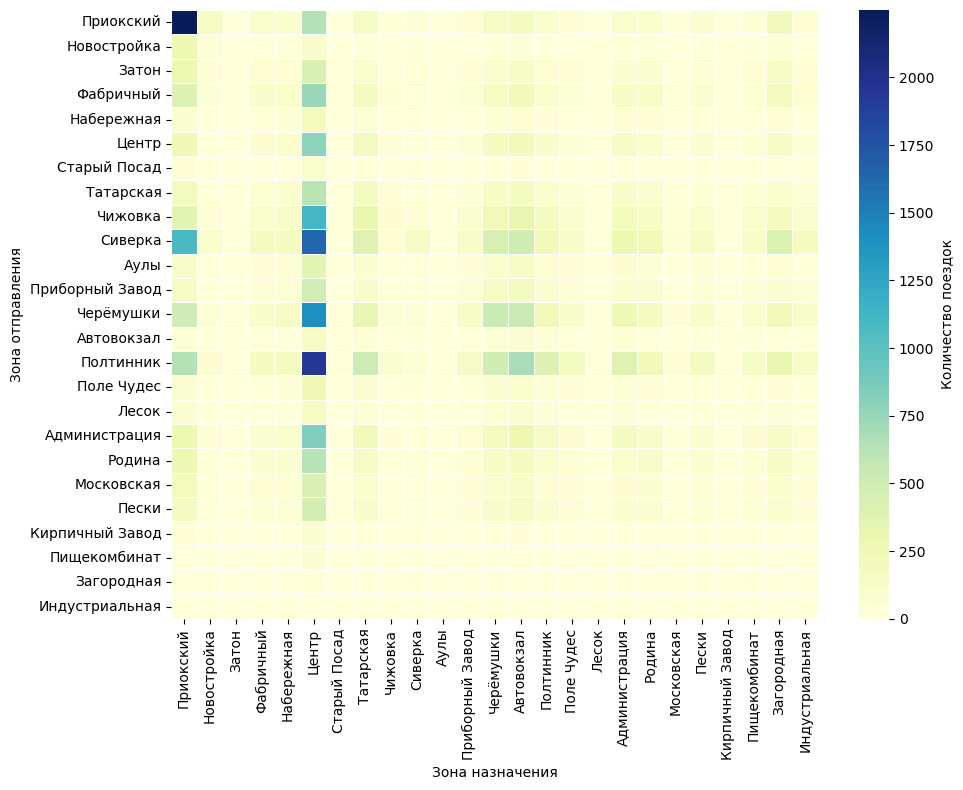

+-----------------+-----------+-------------+-------+-----------+------------+-------+--------------+-----------+---------+---------+------+-----------------+-----------+------------+-----------+------------+-------+---------------+--------+------------+-------+-----------------+--------------+------------+----------------+
|                 | Приокский | Новостройка | Затон | Фабричный | Набережная | Центр | Старый Посад | Татарская | Чижовка | Сиверка | Аулы | Приборный Завод | Черёмушки | Автовокзал | Полтинник | Поле Чудес | Лесок | Администрация | Родина | Московская | Пески | Кирпичный Завод | Пищекомбинат | Загородная | Индустриальная |
+-----------------+-----------+-------------+-------+-----------+------------+-------+--------------+-----------+---------+---------+------+-----------------+-----------+------------+-----------+------------+-------+---------------+--------+------------+-------+-----------------+--------------+------------+----------------+
|    Приокский    |   

/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3008558596.py:129: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = kasimov_trip_model.zoning.gdf_districts.geometry.centroid


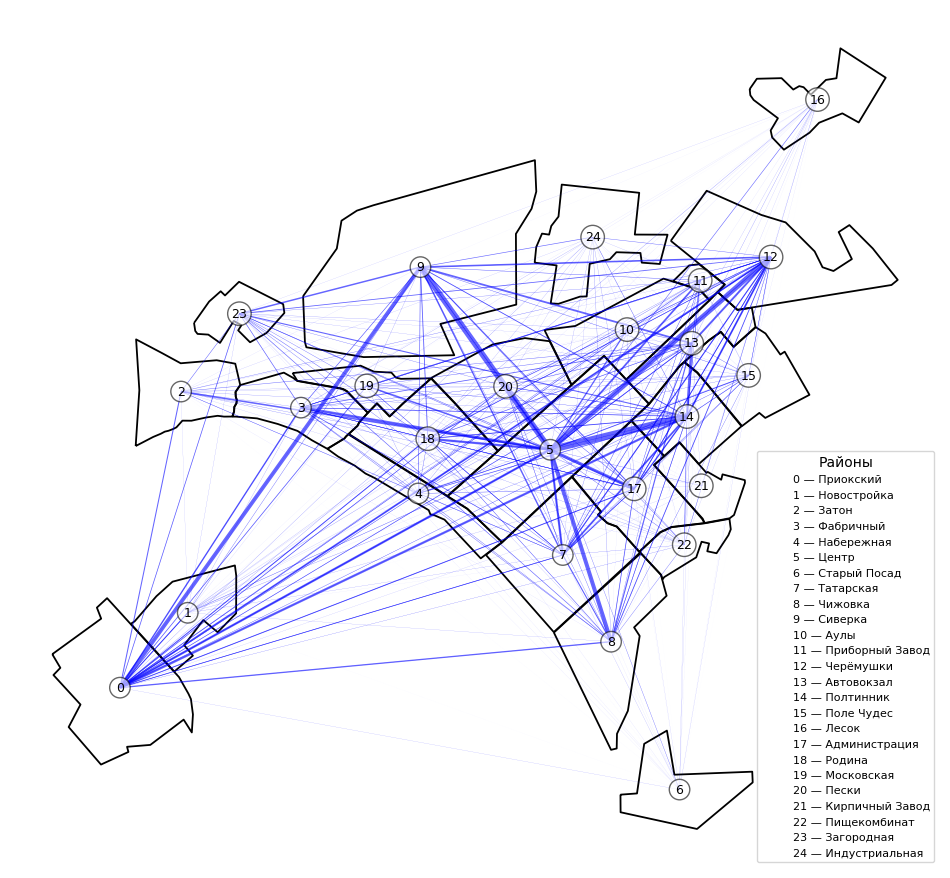

Балансировка: сумма генерации (52713.8496) ≠ сумма притяжения (15529.0)
Сошлось за 7 итераций


/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3008558596.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_centroids = tga.zoning.gdf_districts.geometry.centroid.to_list()


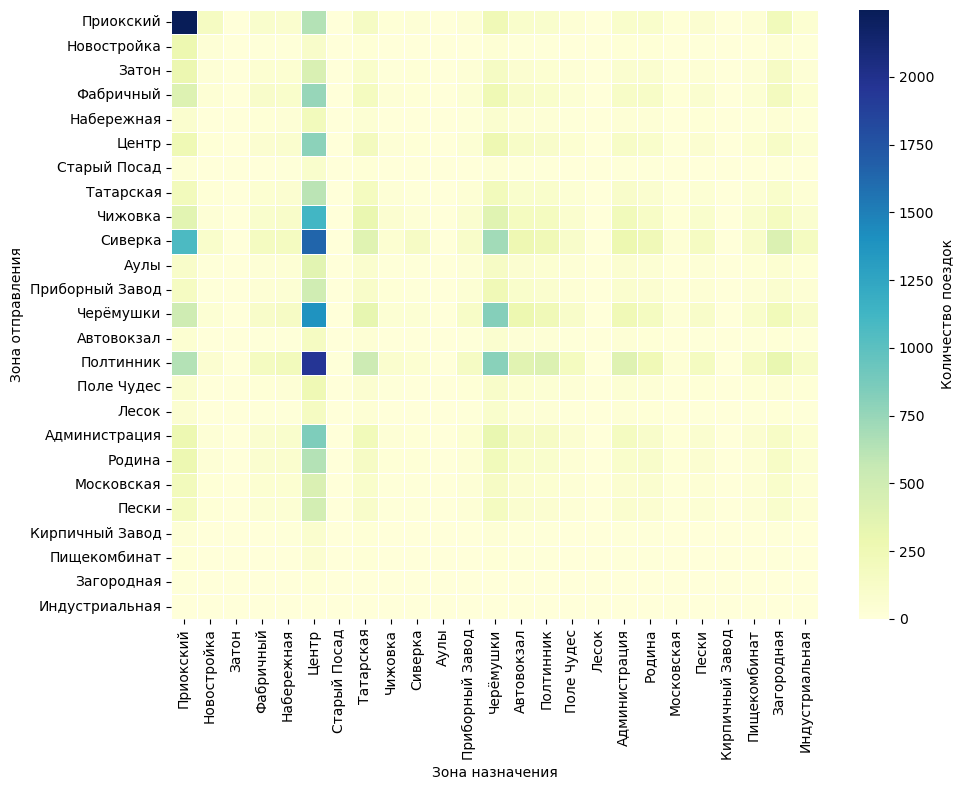

In [53]:
import seaborn as sns
from shapely.geometry import LineString


def build_balanced_gravity_od_matrix_from_tga(tga, graph, gamma=0.1, theta=1.0, max_iter=1000, tol=1e-5):
    """
    Построение сбалансированной OD-матрицы по гравитационной модели
    на основе данных TripGenerationAttraction (tga).
    """
    # Генерация и притяжение из расчётов
    df = tga.df_trips
    num_zones = len(df)

    G = df["generation"].to_numpy(dtype=float)
    A = df["attraction"].to_numpy(dtype=float)

    if G.sum() == 0 or A.sum() == 0:
        print("Недостаточно данных генерации или притяжения.")
        return None

    # Балансировка
    total_G, total_A = G.sum(), A.sum()
    if not np.isclose(total_G, total_A):
        print(f"Балансировка: сумма генерации ({total_G}) ≠ сумма притяжения ({total_A})")
        scale_factor = total_G / total_A
        A *= scale_factor

    # Центры зон
    zone_centroids = tga.zoning.gdf_districts.geometry.centroid.to_list()

    # Определяем ближайшие узлы к центрам зон
    zone_nodes = {
        i: ox.distance.nearest_nodes(graph, zone_centroids[i].x, zone_centroids[i].y)
        for i in range(num_zones)
    }

    # Матрица затрат c_ij = время в пути в минутах
    C = np.full((num_zones, num_zones), np.inf)
    for i in range(num_zones):
        source = zone_nodes[i]
        lengths = nx.single_source_dijkstra_path_length(graph, source, weight="travel_time")
        for j in range(num_zones):
            target = zone_nodes[j]
            if target in lengths:
                C[i, j] = lengths[target] / 60  # минуты

    # Функция тяготения
    with np.errstate(over='ignore'):
        F = np.exp(-gamma * np.power(C, theta))
    F[np.isinf(C)] = 0

    # Итерационная балансировка
    alpha = np.ones(num_zones)
    beta = np.ones(num_zones)

    for iteration in range(max_iter):
        alpha_prev, beta_prev = alpha.copy(), beta.copy()

        # alpha_i
        for i in range(num_zones):
            denom = np.sum(beta * A * F[i, :])
            alpha[i] = 1 / denom if denom > 0 else 0

        # beta_j
        for j in range(num_zones):
            denom = np.sum(alpha * G * F[:, j])
            beta[j] = 1 / denom if denom > 0 else 0

        # Проверка сходимости
        delta_alpha = np.linalg.norm(alpha - alpha_prev)
        delta_beta = np.linalg.norm(beta - beta_prev)
        if delta_alpha < tol and delta_beta < tol:
            print(f"Сошлось за {iteration + 1} итераций")
            break
    else:
        print("Не сошлось за максимальное число итераций")

    # Финальная OD-матрица
    T = np.zeros((num_zones, num_zones))
    for i in range(num_zones):
        for j in range(num_zones):
            T[i, j] = alpha[i] * beta[j] * G[i] * A[j] * F[i, j]

    T_int = np.rint(T).astype(int)
    df_od = pd.DataFrame(
        T_int,
        columns=[f"{zone_name}" for zone_name in tga.zoning.gdf_districts["zone_name"]],
        index=[f"{zone_name}" for zone_name in tga.zoning.gdf_districts["zone_name"]]
    )

    return df_od


def plot_od_matrix(df_od, annot=False):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_od, annot=annot, cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Количество поездок'})
    plt.xlabel("Зона назначения")
    plt.ylabel("Зона отправления")
    # plt.title("OD-матрица")
    plt.tight_layout()
    plt.show()


def save_od_table(df, filename="od_matrix_table.png"):
    fig, ax = plt.subplots(figsize=(len(df.columns)*1.2, len(df)*0.4))
    ax.axis("off")
    table = ax.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.2)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close(fig)


def plot_flows(kasimov_trip_model, od_matrix, threshold=0):
    """
    df_od: OD-матрица (DataFrame)
    zoning: объект с зонами (TransportZoning)
    graph: дорожный граф OSMnx
    threshold: минимальный поток для отображения
    """
    centroids = kasimov_trip_model.zoning.gdf_districts.geometry.centroid
    flows = []

    for i, orig in enumerate(od_matrix.index):
        for j, dest in enumerate(od_matrix.columns):
            val = od_matrix.loc[orig, dest]
            if val > threshold and i != j:  # исключаем поездки внутри района
                line = LineString([centroids[i], centroids[j]])
                flows.append({"geometry": line, "value": val})

    flows_gdf = gpd.GeoDataFrame(flows, crs=kasimov_trip_model.zoning.gdf_districts.crs)

    fig, ax = plt.subplots(figsize=(12, 12))

    kasimov_trip_model.zoning.gdf_districts.boundary.plot(ax=ax, color="black", linewidth=1.3)
    flows_gdf.plot(
        ax=ax, linewidth=flows_gdf["value"] / flows_gdf["value"].max() * 5, alpha=0.6, color="blue"
    )

    # подписи номеров районов
    for row in districts.itertuples():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, str(row.zone_id),
                fontsize=9, ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.6, boxstyle="circle"))
        
    # Легенда по районам
    legend_labels = [f"{row.zone_id} — {row.zone_name}" for row in districts.itertuples()]
    patches = [mpatches.Patch(color="white", label=lbl) for lbl in legend_labels]
    ax.legend(
        handles=patches,
        loc="lower right", fontsize=8, frameon=True,
        title="Районы"
    )
    # plt.title("Desire Lines (OD-потоки)")
    plt.axis("off")
    plt.show()


od_matrix = build_balanced_gravity_od_matrix_from_tga(
    tga=kasimov_trip_model,
    graph=kasimov.graph,
    gamma=0.1,
    theta=1.0
)

plot_od_matrix(od_matrix)

# Отдельный вывод числовой таблицы
from tabulate import tabulate
print(tabulate(od_matrix, headers='keys', tablefmt='pretty'))

save_od_table(od_matrix, "kasimov_data/od_matrix_table.png")

plot_flows(kasimov_trip_model, od_matrix, threshold=0)


od_matrix_new = build_balanced_gravity_od_matrix_from_tga(
    tga=kasimov_trip_model_new,
    graph=kasimov.graph,
    gamma=0.1,
    theta=1.0
)

plot_od_matrix(od_matrix_new)

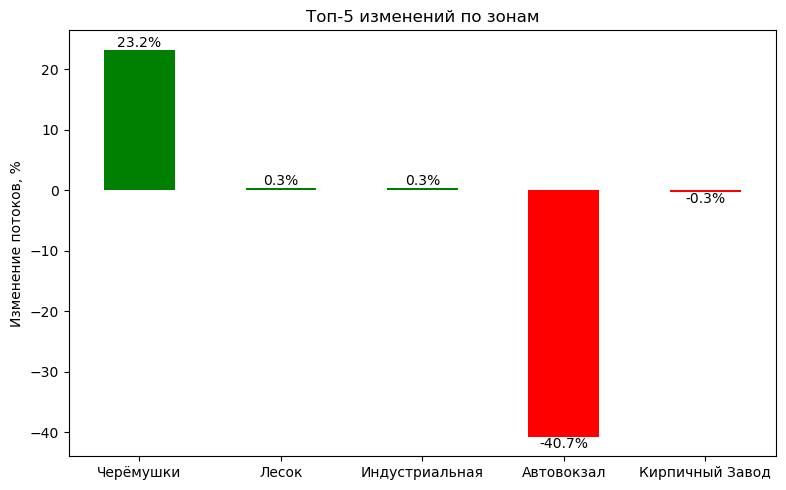

In [54]:
# ===============================
# 3. Разница потоков между сценариями
# ===============================
"""def plot_od_diff_map(df_base, df_new, zoning, graph, threshold=20, title="Разница потоков"):
    districts = zoning.gdf_districts.to_crs(epsg=3857)
    centroids = districts.geometry.centroid

    fig, ax = plt.subplots(figsize=(12, 12))
    districts.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

    diff = df_new - df_base

    for i, origin in enumerate(diff.index):
        for j, dest in enumerate(diff.columns):
            if i != j and abs(diff.iloc[i, j]) > threshold:
                line = gpd.GeoSeries([LineString([
                    centroids.iloc[i], centroids.iloc[j]
                ])], crs=districts.crs)

                color = "green" if diff.iloc[i, j] > 0 else "red"
                line.plot(ax=ax, linewidth=1 + abs(diff.iloc[i, j]) / 200,
                          alpha=0.7, color=color)

    # легенда
    red_patch = mpatches.Patch(color="red", label="Снижение потоков")
    green_patch = mpatches.Patch(color="green", label="Рост потоков")
    ax.legend(handles=[green_patch, red_patch], loc="upper left")

    plt.title(title)
    plt.axis("off")
    plt.show()"""


# ===============================
# 4. Топ-5 изменений
# ===============================
def plot_top5_changes(df_base, df_new, title="Топ-5 изменений по зонам"):
    # считаем суммарные поездки "из зоны"
    base_total = df_base.sum(axis=1) + df_base.sum(axis=0)
    new_total  = df_new.sum(axis=1) + df_new.sum(axis=0)
    diff_pct = (new_total - base_total) / base_total.replace(0, np.nan) * 100

    # топ-3 роста и топ-2 падения
    top5 = pd.concat([diff_pct.sort_values(ascending=False).head(3),
                      diff_pct.sort_values(ascending=True).head(2)])

    fig, ax = plt.subplots(figsize=(8, 5))
    top5.plot(
        kind="bar", 
        ax=ax, 
        color=["green" if v > 0 else "red" for v in top5]
    )
    plt.title(title)
    plt.ylabel("Изменение потоков, %")
    plt.xticks(rotation=0, ha="center")
    # Добавляем подписи над столбцами
    for i, v in enumerate(top5):
        ax.text(i, v, f"{v:.1f}%", 
                ha="center", va="bottom" if v > 0 else "top", fontsize=10)
    plt.tight_layout()
    plt.show()


# plot_od_diff_map(od_matrix, od_matrix_new, kasimov_trip_model.zoning, kasimov.graph, threshold=0)

plot_top5_changes(od_matrix, od_matrix_new)

In [55]:
"""import holoviews as hv
from holoviews import opts
hv.extension('matplotlib')  # можно заменить на 'bokeh' для интерактива
hv.output(size=600)

def plot_chord_od(df):
    zones = df.index.to_list()
    links = []
    for i, origin in enumerate(zones):
        for j, dest in enumerate(zones):
            if df.iloc[i, j] > 0:
                links.append((origin, dest, int(df.iloc[i, j])))

    chord = hv.Chord(links)
    chord.opts(
        opts.Chord(cmap='cet_glasbey_category10',
                   edge_color=hv.dim('source'),
                   labels='index',
                   node_color=hv.dim('index'),
                   edge_cmap='cet_glasbey_category10',
                   edge_alpha=0.8,
                   node_size=10,
                   ))
    return chord

# пример вызова
ch = plot_chord_od(od_matrix)
hv.save(ch, "kasimov_data/od_matrix_chord.png")
ch
"""

'import holoviews as hv\nfrom holoviews import opts\nhv.extension(\'matplotlib\')  # можно заменить на \'bokeh\' для интерактива\nhv.output(size=600)\n\ndef plot_chord_od(df):\n    zones = df.index.to_list()\n    links = []\n    for i, origin in enumerate(zones):\n        for j, dest in enumerate(zones):\n            if df.iloc[i, j] > 0:\n                links.append((origin, dest, int(df.iloc[i, j])))\n\n    chord = hv.Chord(links)\n    chord.opts(\n        opts.Chord(cmap=\'cet_glasbey_category10\',\n                   edge_color=hv.dim(\'source\'),\n                   labels=\'index\',\n                   node_color=hv.dim(\'index\'),\n                   edge_cmap=\'cet_glasbey_category10\',\n                   edge_alpha=0.8,\n                   node_size=10,\n                   ))\n    return chord\n\n# пример вызова\nch = plot_chord_od(od_matrix)\nhv.save(ch, "kasimov_data/od_matrix_chord.png")\nch\n'

In [56]:
"""import pandas as pd
import holoviews as hv
from holoviews import opts, Sankey

def plot_sankey_od(df, top_n=50):
    zones = df.index.to_list()
    links = []
    for i, origin in enumerate(zones):
        for j, dest in enumerate(zones):
            if df.iloc[i, j] > 0 and i != j:
                links.append({'source': origin, 'target': dest, 'value': int(df.iloc[i, j])})

    # фильтрация топ-N
    links = sorted(links, key=lambda x: x['value'], reverse=True)[:top_n]
    links_df = pd.DataFrame(links)

    # Удаляем обратные связи (циклы между двумя зонами)
    seen = set()
    filtered_links = []
    for _, row in links_df.iterrows():
        pair = tuple(sorted([row['source'], row['target']]))
        if pair not in seen:
            filtered_links.append(row)
            seen.add(pair)
    links_df = pd.DataFrame(filtered_links)

    sankey = Sankey(links_df)
    sankey = sankey.opts(
        opts.Sankey(
            cmap='cet_glasbey_category10',
            edge_color=hv.dim('source'),
            node_color=hv.dim('index'),
            labels='index',
            label_text_font_size=14,
            label_position='left'
        )
    )
    return sankey

sank = plot_sankey_od(od_matrix)
hv.save(sank, "kasimov_data/od_matrix_sankey.png")
sank"""

'import pandas as pd\nimport holoviews as hv\nfrom holoviews import opts, Sankey\n\ndef plot_sankey_od(df, top_n=50):\n    zones = df.index.to_list()\n    links = []\n    for i, origin in enumerate(zones):\n        for j, dest in enumerate(zones):\n            if df.iloc[i, j] > 0 and i != j:\n                links.append({\'source\': origin, \'target\': dest, \'value\': int(df.iloc[i, j])})\n\n    # фильтрация топ-N\n    links = sorted(links, key=lambda x: x[\'value\'], reverse=True)[:top_n]\n    links_df = pd.DataFrame(links)\n\n    # Удаляем обратные связи (циклы между двумя зонами)\n    seen = set()\n    filtered_links = []\n    for _, row in links_df.iterrows():\n        pair = tuple(sorted([row[\'source\'], row[\'target\']]))\n        if pair not in seen:\n            filtered_links.append(row)\n            seen.add(pair)\n    links_df = pd.DataFrame(filtered_links)\n\n    sankey = Sankey(links_df)\n    sankey = sankey.opts(\n        opts.Sankey(\n            cmap=\'cet_glasbey_c

In [57]:
"""import holoviews as hv
import matplotlib.pyplot as plt
import colorcet as cc

def plot_chord_od_aggregated(od_matrix, zoning):
    # zone_names и zone_colors
    zone_names = list(zoning.gdf_districts["zone_name"])
    N = len(zone_names)
    # Можно использовать colorcet или matplotlib colormap
    zone_colors = "cet_glasbey_category10"

    # chord_data — ваша матрица/список связей для chord-диаграммы
    # Пример: [(from_zone, to_zone, value), ...]
    chord_data = []
    for i, from_zone in enumerate(zone_names):
        for j, to_zone in enumerate(zone_names):
            value = od_matrix.iloc[i, j]
            if value > 0:
                chord_data.append((from_zone, to_zone, value))

    # Holoviews Chord
    nodes = hv.Dataset(pd.DataFrame({'index': zone_names, 'color': zone_colors}), 'index')
    chord = hv.Chord((chord_data, nodes)).opts(
        opts.Chord(
            labels='index',
            node_color='cet_glasbey_category10',
            edge_color='cet_glasbey_category10',
            cmap=zone_colors,
            edge_cmap=zone_colors,
            edge_alpha=0.7,
            node_size=15,
        )
    )

    # Кастомная легенда через NdOverlay
    legend_items = {}
    for name, color in zip(zone_names, zone_colors):
        legend_items[name] = hv.Curve([]).opts(color=color, linewidth=6)
    legend_overlay = hv.NdOverlay(legend_items, kdims=["Район"]).opts(
        opts.NdOverlay(
            legend_position='right',
            show_legend=True,
            title="Районы"
        )
    )

    # Совместное отображение
    layout = (chord + legend_overlay).opts(opts.Layout(shared_axes=False))
    return layout

# Пример вызова:
layout = plot_chord_od_aggregated(od_matrix, zoning)
layout"""

'import holoviews as hv\nimport matplotlib.pyplot as plt\nimport colorcet as cc\n\ndef plot_chord_od_aggregated(od_matrix, zoning):\n    # zone_names и zone_colors\n    zone_names = list(zoning.gdf_districts["zone_name"])\n    N = len(zone_names)\n    # Можно использовать colorcet или matplotlib colormap\n    zone_colors = "cet_glasbey_category10"\n\n    # chord_data — ваша матрица/список связей для chord-диаграммы\n    # Пример: [(from_zone, to_zone, value), ...]\n    chord_data = []\n    for i, from_zone in enumerate(zone_names):\n        for j, to_zone in enumerate(zone_names):\n            value = od_matrix.iloc[i, j]\n            if value > 0:\n                chord_data.append((from_zone, to_zone, value))\n\n    # Holoviews Chord\n    nodes = hv.Dataset(pd.DataFrame({\'index\': zone_names, \'color\': zone_colors}), \'index\')\n    chord = hv.Chord((chord_data, nodes)).opts(\n        opts.Chord(\n            labels=\'index\',\n            node_color=\'cet_glasbey_category10\',\n  

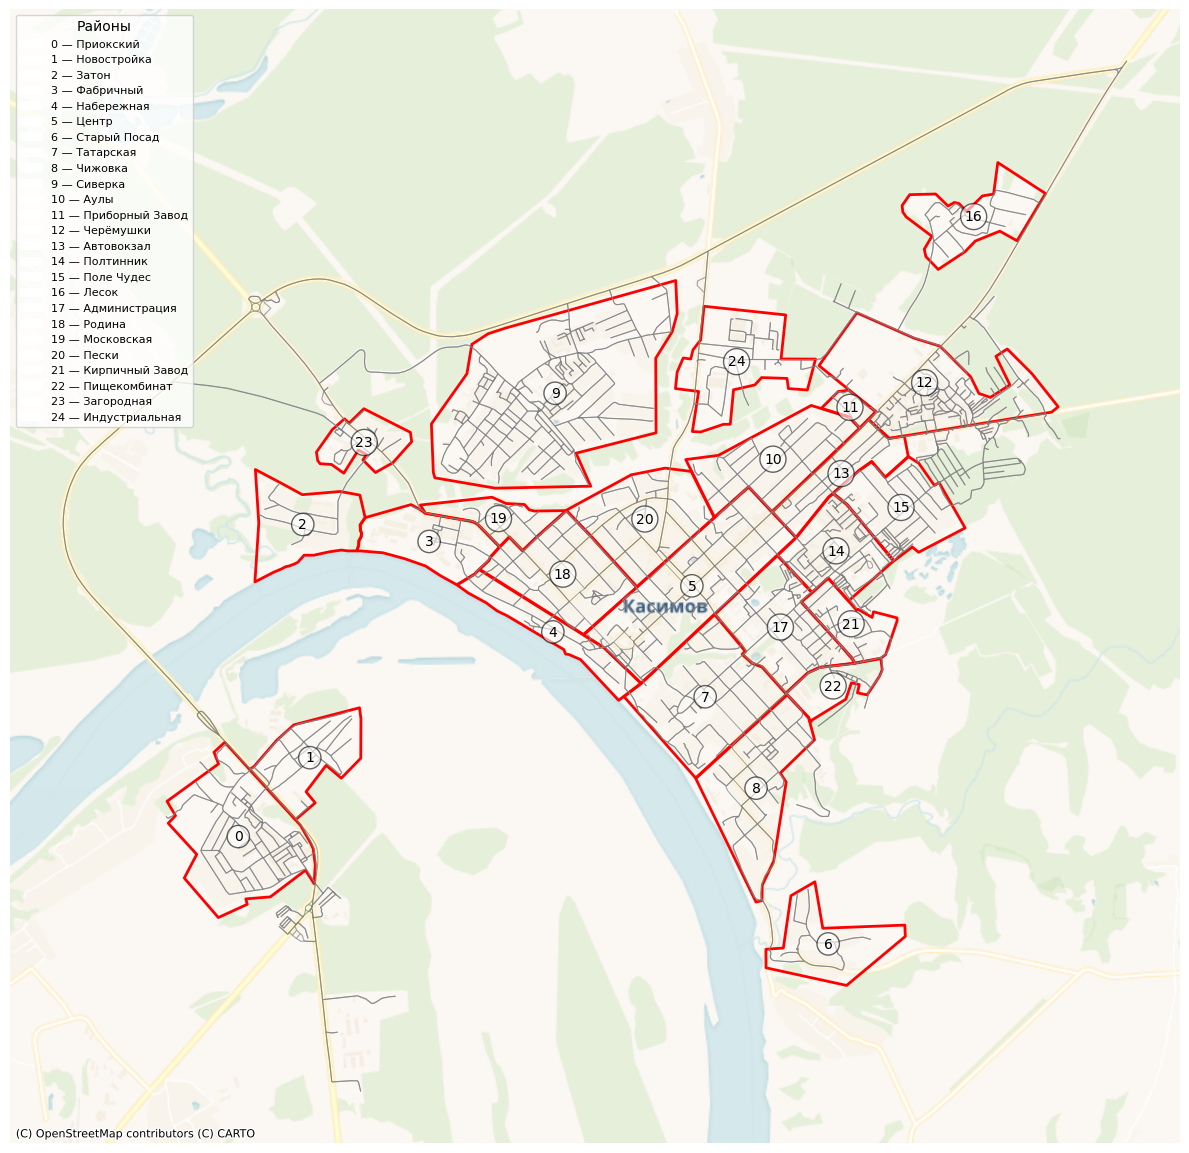

In [58]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import osmnx as ox
import networkx as nx
import matplotlib.patches as mpatches

class TransportZoning:
    def __init__(self, city_graph: nx.MultiDiGraph, geojson_path: str):
        self.graph = city_graph
        self.geojson_path = geojson_path
        self.zone_assignments = {}  # node_id -> zone_id
        self.gdf_districts = None  # GeoDataFrame зон

    def load_real_zones(self):
        """Загрузка реальных границ из GeoJSON"""
        districts = gpd.read_file(self.geojson_path)

        # CRS
        if districts.crs is None:
            districts.set_crs(epsg=4326, inplace=True)
        elif districts.crs.to_epsg() != 4326:
            districts = districts.to_crs(epsg=4326)

        # zone_id и zone_name
        districts = districts.reset_index(drop=True)
        districts["zone_id"] = districts.index
        if "name" not in districts.columns:
            districts["zone_name"] = [f"Зона {i}" for i in range(len(districts))]
        else:
            districts.rename(columns={"name": "zone_name"}, inplace=True)

        self.gdf_districts = districts

    def rename_zones(self, mapping: dict):
        """Переименовать районы"""
        if self.gdf_districts is None:
            raise ValueError("Сначала вызовите load_real_zones()")
        self.gdf_districts["zone_name"] = self.gdf_districts["zone_name"].replace(mapping)

    def assign_nodes_to_zones(self):
        """Присвоить узлы графа районам"""
        if self.gdf_districts is None:
            raise ValueError("Сначала вызовите load_real_zones()")

        nodes_data = [
            (nid, data["x"], data["y"])
            for nid, data in self.graph.nodes(data=True)
        ]
        df_nodes = pd.DataFrame(nodes_data, columns=["node_id", "x", "y"])
        gdf_nodes = gpd.GeoDataFrame(
            df_nodes, geometry=gpd.points_from_xy(df_nodes.x, df_nodes.y), crs="EPSG:4326"
        )

        joined = gpd.sjoin(gdf_nodes, self.gdf_districts, how="left", predicate="within")

        for row in joined.itertuples():
            zone_id = int(row.zone_id) if pd.notnull(row.zone_id) else None
            self.graph.nodes[row.node_id]["zone"] = zone_id
            if zone_id is not None:
                self.zone_assignments[row.node_id] = zone_id

    def visualize_zones_with_numbers(self):
        """Визуализация с номерами районов"""
        if self.gdf_districts is None:
            raise ValueError("Нет загруженных границ зон")

        # Переводим в Web Mercator
        districts_web = self.gdf_districts.to_crs(epsg=3857)
        gdf_edges = ox.graph_to_gdfs(self.graph, nodes=False, edges=True).to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(12, 12))

        # Границы всех районов одним цветом
        districts_web.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

        # Подписи номеров в центрах районов
        for row in districts_web.itertuples():
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, str(row.zone_id),
                    fontsize=10, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.6, boxstyle="circle"))

        # Дорожная сеть
        gdf_edges.plot(ax=ax, linewidth=0.8, color="gray", alpha=0.7)

        # Подложка Voyager
        cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

        # Легенда: номер → название
        legend_labels = [f"{row.zone_id} — {row.zone_name}" for row in districts_web.itertuples()]
        patches = [mpatches.Patch(color="white", label=lbl) for lbl in legend_labels]
        ax.legend(handles=patches, loc="upper left", fontsize=8, frameon=True, title="Районы")

        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

    def export_zone_assignments(self, filepath='kasimov_data/node_zone_assignments.csv'):
        df = pd.DataFrame([
            {"node_id": node_id, "zone_id": zone_id}
            for node_id, zone_id in self.zone_assignments.items()
        ])
        df.to_csv(filepath, index=False)

    def export_zones_shapefile(self, filepath='kasimov_data/zones.geojson'):
        if self.gdf_districts is not None:
            self.gdf_districts.to_file(filepath, driver="GeoJSON")


geojson_path = "kasimov_data/map.geojson"
zoning = TransportZoning(kasimov.graph, geojson_path)

zoning.load_real_zones()

rename_map = {
    "Зона 0": "Приокский",
    "Зона 1": "Новостройка",
    "Зона 2": "Затон",
    "Зона 3": "Фабричный",
    "Зона 4": "Набережная",
    "Зона 5": "Центр",
    "Зона 6": "Старый Посад",
    "Зона 7": "Татарская",
    "Зона 8": "Чижовка",
    "Зона 9": "Сиверка",
    "Зона 10": "Аулы",
    "Зона 11": "Приборный Завод",
    "Зона 12": "Черёмушки",
    "Зона 13": "Автовокзал",
    "Зона 14": "Полтинник",
    "Зона 15": "Поле Чудес",
    "Зона 16": "Лесок",
    "Зона 17": "Администрация",
    "Зона 18": "Родина",
    "Зона 19": "Московская",
    "Зона 20": "Пески",
    "Зона 21": "Кирпичный Завод",
    "Зона 22": "Пищекомбинат",
    "Зона 23": "Загородная",
    "Зона 24": "Индустриальная",
}
zoning.rename_zones(rename_map)

zoning.assign_nodes_to_zones()
zoning.visualize_zones_with_numbers()

Загружено POI объектов: 671
Зона 0: Генераторов — 19, Аттракторов — 8
Зона 1: Генераторов — 1, Аттракторов — 14
Зона 2: Генераторов — 3, Аттракторов — 3
Зона 3: Генераторов — 15, Аттракторов — 16
Зона 4: Генераторов — 4, Аттракторов — 5
Зона 5: Генераторов — 24, Аттракторов — 33
Зона 6: Генераторов — 0, Аттракторов — 1
Зона 7: Генераторов — 54, Аттракторов — 6
Зона 8: Генераторов — 18, Аттракторов — 4
Зона 9: Генераторов — 42, Аттракторов — 1
Зона 10: Генераторов — 1, Аттракторов — 0
Зона 11: Генераторов — 4, Аттракторов — 0
Зона 12: Генераторов — 69, Аттракторов — 7
Зона 13: Генераторов — 49, Аттракторов — 8
Зона 14: Генераторов — 27, Аттракторов — 2
Зона 15: Генераторов — 8, Аттракторов — 2
Зона 16: Генераторов — 6, Аттракторов — 0
Зона 17: Генераторов — 11, Аттракторов — 5
Зона 18: Генераторов — 97, Аттракторов — 3
Зона 19: Генераторов — 19, Аттракторов — 0
Зона 20: Генераторов — 17, Аттракторов — 1
Зона 21: Генераторов — 5, Аттракторов — 1
Зона 22: Генераторов — 0, Аттракторов — 8


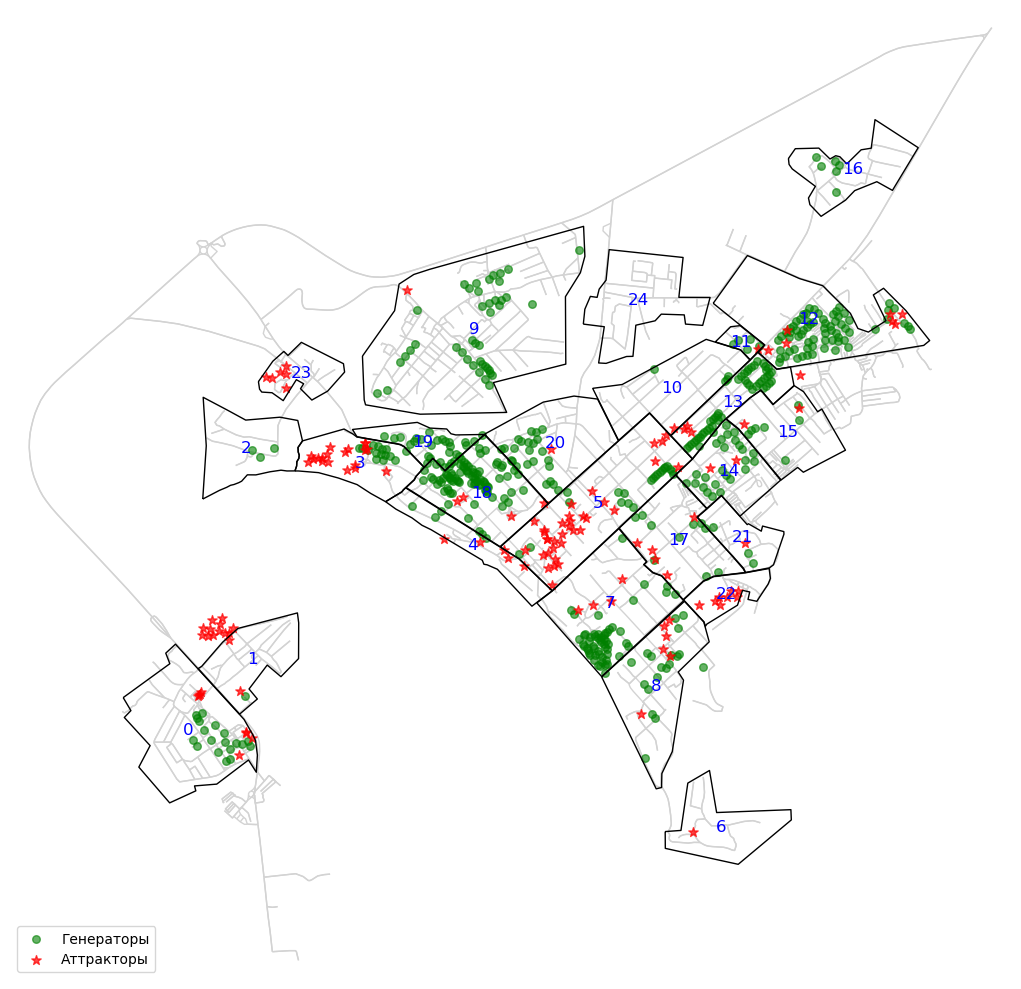

In [59]:
import osmnx as ox
from shapely.geometry import Point
from collections import defaultdict
import geopandas as gpd
import matplotlib.pyplot as plt

class TrafficAttractorAnalyzer:
    def __init__(self, city_graph, zoning: TransportZoning):
        self.graph = city_graph
        self.zoning = zoning
        self.generators = defaultdict(list)
        self.attractors = defaultdict(list)

    def _get_zone_by_node(self, node_id):
        return self.graph.nodes[node_id].get("zone")

    def _nearest_node_zone(self, point: Point):
        nearest_node = ox.distance.nearest_nodes(self.graph, X=point.x, Y=point.y)
        return self._get_zone_by_node(nearest_node)

    def extract_pois(self, lat=54.937289, lon=41.391369, dist=4000):
        tags = {
            "amenity": ["bus_station", "school", "music_school", "college", "university", "kindergarten", "bar", "cafe", "fast_food", 
                        "restaurant", "clinic", "hospital", "community_centre", "ferry_terminal", "food_court", "training", "dentist",
                        "nursing_home", "veterinary", "cinema", "theatre", "library", "pharmacy", "bank", "post_office",
                        "marketplace", "nightclub", "place_of_worship", "driving_school", "arts_centre", "events_venue", "exhibition_centre",
                        ],
            "building": ["residential", "apartments", "house", "cabin", "detached", "semidetached_house", "bungalow", "farm", 
                         "terrace", "hotel", "industrial", "office", "supermarket", "mosque", "church", "synagogue", "temple",
                         "cathedral", "chapel", "shrine", "religious"]
        }

        gdf = ox.features.features_from_point((lat, lon), tags, dist=dist)
        print(f"Загружено POI объектов: {len(gdf)}")

        gdf = gdf.copy()
        gdf["geometry"] = gdf.geometry.apply(lambda geom: geom.centroid if geom.geom_type != "Point" else geom)

        for _, row in gdf.iterrows():
            point = row.geometry
            zone = self._nearest_node_zone(point)
            if zone is None:
                continue

            if row.get("amenity") in tags["amenity"] or row.get("building") in ["industrial", "office","supermarket", "mosque", 
                                                                                "church", "synagogue", "temple", "cathedral",
                                                                                "chapel", "shrine", "religious"]:
                self.attractors[zone].append(row)
            elif row.get("building") in ["residential", "apartments", "house", "cabin", "detached",
                                         "semidetached_house", "bungalow", "farm", "terrace", "hotel"]:
                self.generators[zone].append(row)

    def summary(self):
        for zone_id in range(len(self.zoning.gdf_districts)):
            print(f"Зона {zone_id}: Генераторов — {len(self.generators[zone_id])}, Аттракторов — {len(self.attractors[zone_id])}")

    def list_poi_names(self):
        for zone_id in range(len(self.zoning.gdf_districts)):
            print(f"\n--- Зона {zone_id} ({self.zoning.gdf_districts.loc[zone_id, 'zone_name']}) ---")
            print("  Аттракторы:")
            if self.attractors[zone_id]:
                for poi in self.attractors[zone_id]:
                    print(f"    - {poi.get('name', '(без названия)')} ({poi.get('amenity') or poi.get('building')})")
            else:
                print("    (нет аттракторов)")
            
            print("  Генераторы:")
            if self.generators[zone_id]:
                for poi in self.generators[zone_id]:
                    print(f"    - {poi.get('name', '(без названия)')} ({poi.get('building')})")
            else:
                print("    (нет генераторов)")

    def plot_attractors_generators(self):
        fig, ax = plt.subplots(figsize=(12, 10))

        # Фон — дорожная сеть
        ox.plot_graph(self.graph, ax=ax, show=False, close=False, edge_color="lightgray", node_size=0)

        # Контуры зон
        self.zoning.gdf_districts.boundary.plot(ax=ax, color="black", linewidth=1)

        # Подписи зон
        for idx, row in self.zoning.gdf_districts.iterrows():
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
            ax.text(x, y, str(idx), fontsize=12, color="blue", ha="center", va="center")

        # Генераторы
        for rows in self.generators.values():
            points = [row.geometry for row in rows if row.geometry.geom_type == "Point"]
            if points:
                xs, ys = zip(*[(pt.x, pt.y) for pt in points])
                ax.scatter(xs, ys, c="green", s=30, label="Генераторы", alpha=0.6)

        # Аттракторы
        for rows in self.attractors.values():
            points = [row.geometry for row in rows if row.geometry.geom_type == "Point"]
            if points:
                xs, ys = zip(*[(pt.x, pt.y) for pt in points])
                ax.scatter(xs, ys, c="red", s=50, marker="*", label="Аттракторы", alpha=0.7)

        ax.axis("off")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc="lower left")
        plt.tight_layout()
        plt.show()


attractor_analyzer = TrafficAttractorAnalyzer(
    city_graph=kasimov.graph,
    zoning=zoning
)

attractor_analyzer.extract_pois()
attractor_analyzer.summary()
attractor_analyzer.list_poi_names()
attractor_analyzer.plot_attractors_generators()

/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/2757182796.py:132: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poi_gdf["geometry"] = poi_gdf.geometry.centroid


    zone  generation  attraction
0      0    2000.636        1880
1      1    2000.636        4150
2      2    2000.636        1210
3      3    2000.636        4090
4      4    2000.636         945
5      5    2000.636        5875
6      6    2000.636         970
7      7    2000.636        2165
8      8    2000.636         885
9      9    2000.636        3510
10    10    2000.636         970
11    11    2000.636         100
12    12    2000.636        3060
13    13    2000.636        3150
14    14    2000.636        1280
15    15    2000.636         830
16    16    2000.636          80
17    17    2000.636        3970
18    18    2000.636        5000
19    19    2000.636        1410
20    20    2000.636        1880
21    21    2000.636        1060
22    22    2000.636        2660
23    23    2000.636         410
24    24    2000.636         400


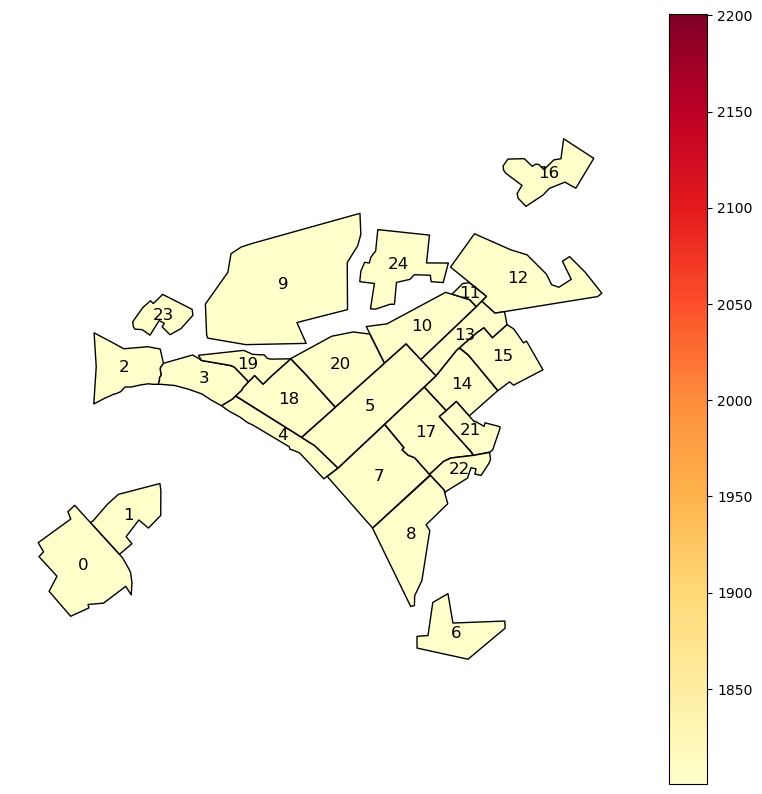

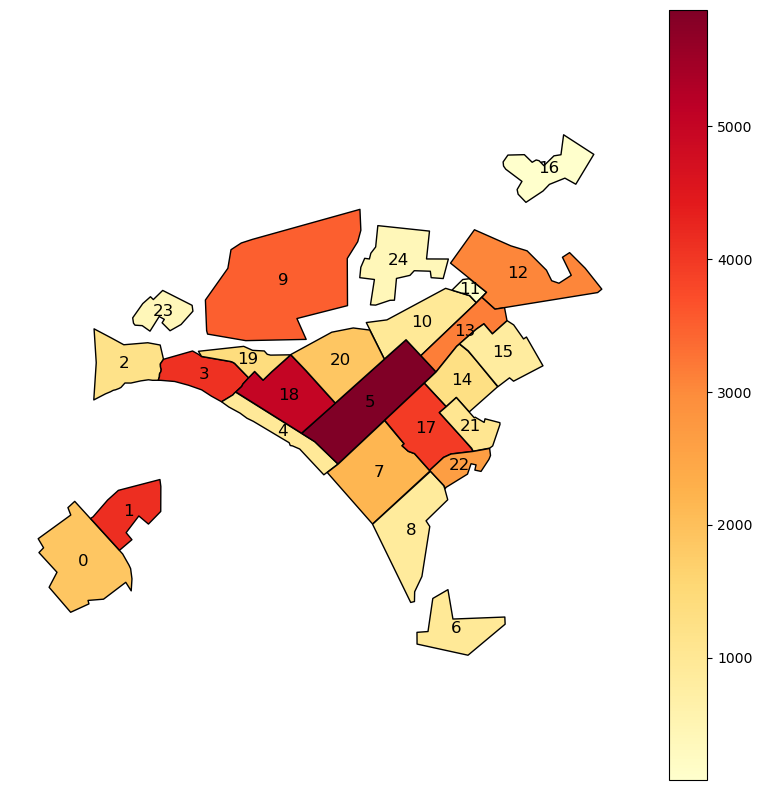

In [60]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import Point

class TripGenerationAttraction:
    def __init__(self, zoning):
        self.zoning = zoning
        self.graph = zoning.graph
        self.production = {}
        self.attraction = {}
        self.generators = {}
        self.attractors = {}
        self.df_trips = None

        # Инициализация пустых списков для всех зон
        for zone_id in zoning.gdf_districts.index:
            self.generators[zone_id] = []
            self.attractors[zone_id] = []

    def _get_zone_by_node(self, node_id):
        """Возвращает зону для узла графа"""
        return self.graph.nodes[node_id].get("zone")

    def _nearest_node_zone(self, point: Point):
        """Находит ближайший узел графа и возвращает его зону"""
        nearest_node = ox.distance.nearest_nodes(self.graph, X=point.x, Y=point.y)
        return self._get_zone_by_node(nearest_node)

    def assign_zones_to_pois(self, poi_gdf):
        """Добавляет колонку 'zone' через ближайший узел графа"""
        poi_gdf = poi_gdf.copy()
        poi_gdf["zone"] = poi_gdf.geometry.apply(lambda geom: self._nearest_node_zone(geom))
        return poi_gdf

    def calculate_from_population_and_jobs(self, population_data, poi_gdf):
        """Расчет генерации и притяжения"""

        # --- Генерация ---
        for zone_id, pop in population_data.items():
            kids_trips = pop["kids"] * 0.5
            school_trips = pop["school"] * 1.8
            youth_trips = pop["youth"] * 2.0
            adult_trips = pop["adults"] * 2.2
            elderly_trips = pop["elderly"] * 1.2
            # student_trips = pop.get("students", 0) * 2.2

            total_generation = kids_trips + school_trips + youth_trips + adult_trips + elderly_trips # + student_trips
            self.production[zone_id] = total_generation

        # --- Притяжение ---
        self.attraction = {zone_id: 0 for zone_id in self.zoning.gdf_districts.index}
        for _, row in poi_gdf.iterrows():
            zone_id = row["zone"]
            if pd.isna(zone_id):
                continue
            if row.get("amenity") in ["school", "college", "university", "kindergarten"]:
                self.attraction[zone_id] += 100
            elif row.get("amenity") in ["hospital", "clinic", "dentist"]:
                self.attraction[zone_id] += 50
            elif row.get("amenity") in ["supermarket", "marketplace", "mall"]:
                self.attraction[zone_id] += 150
            elif row.get("industrial") or row.get("building") in ["industrial", "factory", "office"]:
                self.attraction[zone_id] += 300
            elif row.get("amenity") in ["bar", "cafe", "fast_food", "restaurant", "cinema", "theatre", "food_court"]:
                self.attraction[zone_id] += 100
            elif row.get("amenity") in ["bank", "post_office", "pharmacy"]:
                self.attraction[zone_id] += 20
            elif row.get("amenity") in ["bus_station", "ferry_terminal"]:
                self.attraction[zone_id] += 30
            elif row.get("building") in ["mosque", "church", "synagogue", "temple"]:
                self.attraction[zone_id] += 15
            else:
                self.attraction[zone_id] += 10

        # --- Результат ---
        df = pd.DataFrame({
            "zone": list(self.zoning.gdf_districts.index),
            "generation": [self.production[z] for z in self.zoning.gdf_districts.index],
            "attraction": [self.attraction[z] for z in self.zoning.gdf_districts.index]
        })
        self.df_trips = df
        return df

    def plot_heatmap(self, df, value_col="generation", title="Тепловая карта"):
        """Тепловая карта значений по зонам"""
        gdf = self.zoning.gdf_districts.merge(df, left_index=True, right_on="zone")
        fig, ax = plt.subplots(figsize=(10, 10))
        gdf.plot(column=value_col, ax=ax, cmap="YlOrRd", legend=True, edgecolor="black")
        
        # Подписи в центре зон
        """for idx, row in gdf.iterrows():
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
            ax.text(x, y, f"{row[value_col]:.0f}", ha="center", va="center", fontsize=8, color="black")"""
        
        # Подписи зон
        for idx, row in self.zoning.gdf_districts.iterrows():
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
            ax.text(x, y, str(idx), fontsize=12, color="black", ha="center", va="center")

        # plt.title(title)
        plt.axis("off")
        plt.show()

# --- 1. Формируем население по зонам ---
total_pop = 29240
zones_count = len(zoning.gdf_districts)
population_data = {}

for z in range(zones_count):
    share = 1 / zones_count
    population_data[z] = {
        "total": total_pop * share,
        "kids": 2913 * share,
        "school": 3461 * share,
        "youth": 3498 * share,
        "adults": 12584 * share,
        "elderly": 6374 * share,
        # "students": 1800 * share
    }

# --- 2. Загружаем POI ---
poi_gdf = ox.features.features_from_point(
    (54.937289, 41.391369),
    tags={
        "amenity": True,
        "building": True,
    },
    dist=4000
)
poi_gdf["geometry"] = poi_gdf.geometry.centroid

# --- 3. Привязка к зонам ---
tga = TripGenerationAttraction(zoning)
poi_gdf = tga.assign_zones_to_pois(poi_gdf)

# --- 4. Расчет ---
df_trips = tga.calculate_from_population_and_jobs(population_data, poi_gdf)
print(df_trips)

# --- 5. Визуализация ---
tga.plot_heatmap(df_trips, value_col="generation", title="Генерация поездок — тепловая карта")
tga.plot_heatmap(df_trips, value_col="attraction", title="Притяжение поездок — тепловая карта")

Балансировка: сумма генерации (50015.9) ≠ сумма притяжения (51940.0)


/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/650108417.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_centroids = tga.zoning.gdf_districts.geometry.centroid.to_list()


Сошлось за 6 итераций


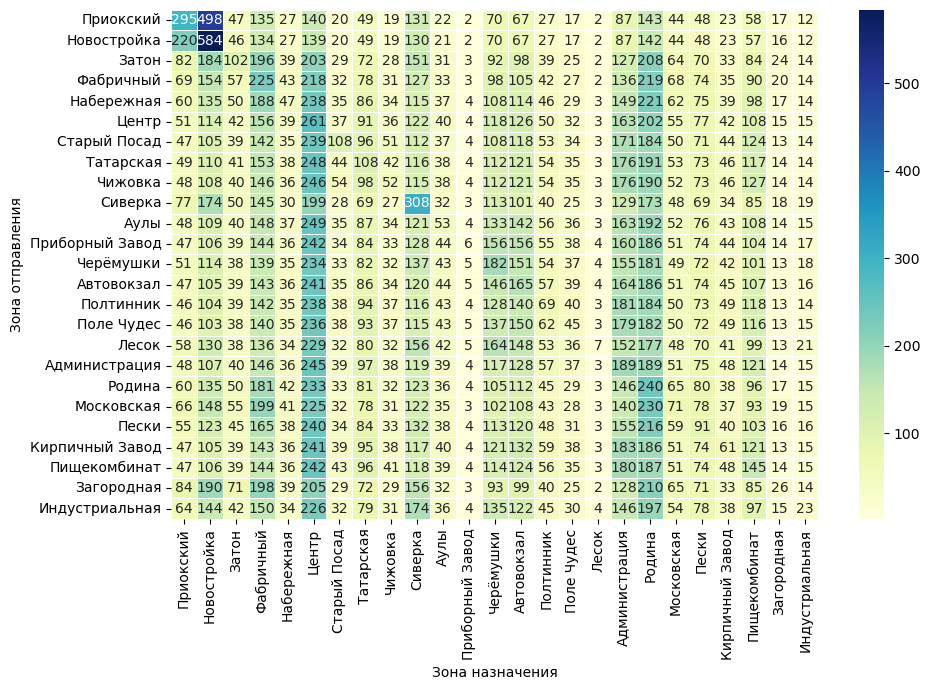

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import osmnx as ox

def build_balanced_gravity_od_matrix_from_tga(tga, graph, gamma=0.1, theta=1.0, max_iter=1000, tol=1e-5):
    """
    Построение сбалансированной OD-матрицы по гравитационной модели
    на основе данных TripGenerationAttraction (tga).
    """
    # Генерация и притяжение из расчётов
    df = tga.df_trips
    num_zones = len(df)

    G = df["generation"].to_numpy(dtype=float)
    A = df["attraction"].to_numpy(dtype=float)

    if G.sum() == 0 or A.sum() == 0:
        print("Недостаточно данных генерации или притяжения.")
        return None

    # Балансировка
    total_G, total_A = G.sum(), A.sum()
    if not np.isclose(total_G, total_A):
        print(f"Балансировка: сумма генерации ({total_G}) ≠ сумма притяжения ({total_A})")
        scale_factor = total_G / total_A
        A *= scale_factor

    # Центры зон
    zone_centroids = tga.zoning.gdf_districts.geometry.centroid.to_list()

    # Определяем ближайшие узлы к центрам зон
    zone_nodes = {
        i: ox.distance.nearest_nodes(graph, zone_centroids[i].x, zone_centroids[i].y)
        for i in range(num_zones)
    }

    # Матрица затрат c_ij = время в пути в минутах
    C = np.full((num_zones, num_zones), np.inf)
    for i in range(num_zones):
        source = zone_nodes[i]
        lengths = nx.single_source_dijkstra_path_length(graph, source, weight="travel_time")
        for j in range(num_zones):
            target = zone_nodes[j]
            if target in lengths:
                C[i, j] = lengths[target] / 60  # минуты

    # Функция тяготения
    with np.errstate(over='ignore'):
        F = np.exp(-gamma * np.power(C, theta))
    F[np.isinf(C)] = 0

    # Итерации балансировки
    alpha = np.ones(num_zones)
    beta = np.ones(num_zones)

    for iteration in range(max_iter):
        alpha_prev, beta_prev = alpha.copy(), beta.copy()

        # alpha_i
        for i in range(num_zones):
            denom = np.sum(beta * A * F[i, :])
            alpha[i] = 1 / denom if denom > 0 else 0

        # beta_j
        for j in range(num_zones):
            denom = np.sum(alpha * G * F[:, j])
            beta[j] = 1 / denom if denom > 0 else 0

        # Проверка сходимости
        delta_alpha = np.linalg.norm(alpha - alpha_prev)
        delta_beta = np.linalg.norm(beta - beta_prev)
        if delta_alpha < tol and delta_beta < tol:
            print(f"Сошлось за {iteration + 1} итераций")
            break
    else:
        print("Не сошлось за максимальное число итераций")

    # Финальная OD-матрица
    T = np.zeros((num_zones, num_zones))
    for i in range(num_zones):
        for j in range(num_zones):
            T[i, j] = alpha[i] * beta[j] * G[i] * A[j] * F[i, j]

    T_int = np.rint(T).astype(int)
    df_od = pd.DataFrame(
        T_int,
        columns=[f"{zone_name}" for zone_name in tga.zoning.gdf_districts["zone_name"]],
        index=[f"{zone_name}" for zone_name in tga.zoning.gdf_districts["zone_name"]]
    )

    # Визуализация тепловой карты
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_od, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
    # plt.title("OD-матрица (балансировочная гравитационная модель)")
    plt.xlabel("Зона назначения")
    plt.ylabel("Зона отправления")
    plt.tight_layout()
    plt.show()

    return df_od


# Сначала расчёт генерации/притяжения
tga = TripGenerationAttraction(zoning)
df_trips = tga.calculate_from_population_and_jobs(population_data, poi_gdf)

# OD-матрица
od_matrix = build_balanced_gravity_od_matrix_from_tga(
    tga=tga,
    graph=kasimov.graph,
    gamma=0.1,
    theta=1.0
)

/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/1579585203.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = group.unary_union.convex_hull
/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/1579585203.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = group.unary_union.convex_hull
/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/1579585203.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = group.unary_union.convex_hull
/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/1579585203.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = group.unary_union.convex_hull
/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/1579585203.py:42: DeprecationWa

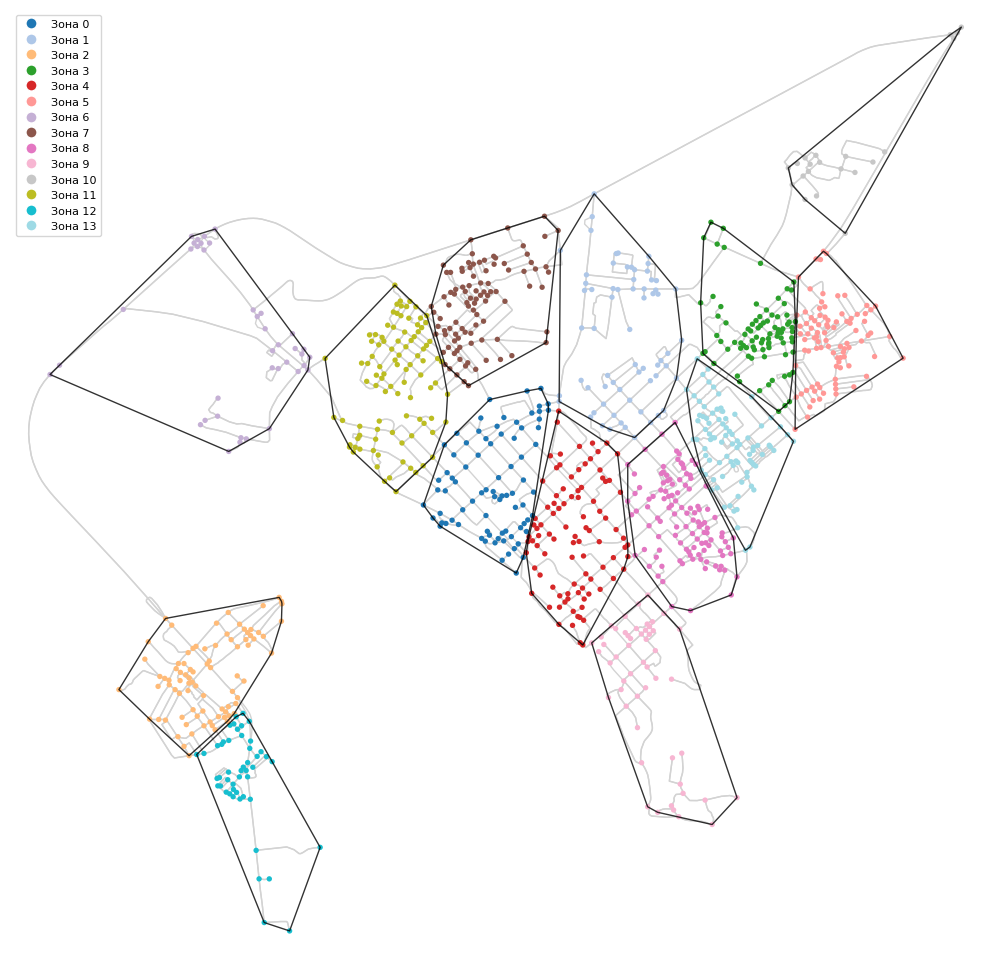

In [62]:
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans


class TransportZoning:
    def __init__(self, city_graph: nx.MultiDiGraph, num_zones: int = 10):
        self.graph = city_graph
        self.num_zones = num_zones
        self.zone_assignments = {}  # node_id -> zone_id
        self.gdf_districts = None  # GeoDataFrame зон

    def generate_zones_kmeans(self):
        # Извлекаем координаты всех узлов
        nodes = [(nid, data['x'], data['y']) for nid, data in self.graph.nodes(data=True)]
        node_ids = [n[0] for n in nodes]
        coords = [[n[1], n[2]] for n in nodes]

        # кластеризация координат узлов
        kmeans = KMeans(n_clusters=self.num_zones, random_state=42, n_init=10)
        labels = kmeans.fit_predict(coords)

        self.zone_assignments = {node_ids[i]: int(labels[i]) for i in range(len(node_ids))}

        # добавляем к графу информацию о зоне
        for node_id, zone_id in self.zone_assignments.items():
            self.graph.nodes[node_id]['zone'] = zone_id

        # Построение GeoDataFrame для зон
        df_nodes = pd.DataFrame({
            "node_id": node_ids,
            "zone_id": labels,
            "x": [pt[0] for pt in coords],
            "y": [pt[1] for pt in coords],
        })
        gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry=gpd.points_from_xy(df_nodes["x"], df_nodes["y"]), crs="EPSG:4326")

        # Группируем по зонам и строим Convex Hull для каждой зоны
        districts = []
        for zone_id, group in gdf_nodes.groupby("zone_id"):
            if len(group) >= 3:
                polygon = group.unary_union.convex_hull
            else:
                polygon = group.unary_union.envelope  # fallback
            districts.append({"zone_id": zone_id, "geometry": polygon})

        self.gdf_districts = gpd.GeoDataFrame(districts, crs="EPSG:4326")

    def visualize_zones(self):
        zone_colors = plt.cm.get_cmap("tab20", self.num_zones)

        fig, ax = plt.subplots(figsize=(10, 10))

        # Цвета узлов
        node_colors = [
            zone_colors(self.graph.nodes[n]['zone']) if 'zone' in self.graph.nodes[n] else (0.5, 0.5, 0.5)
            for n in self.graph.nodes
        ]
        ox.plot_graph(self.graph, node_color=node_colors, node_size=15, edge_color="lightgray", show=False, close=False, ax=ax)

        # Рисуем зоны
        if self.gdf_districts is not None:
            self.gdf_districts.plot(ax=ax, edgecolor="black", alpha=0.8, facecolor="none")

        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label=f'Зона {i}', 
                       markerfacecolor=zone_colors(i), markersize=8)
            for i in range(self.num_zones)
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=8)
        # ax.set_title("Разбиение на транспортные зоны")
        plt.tight_layout()
        plt.show()

    def export_zone_assignments(self, filepath='kasimov_data/node_zone_assignments.csv'):
        df = pd.DataFrame([
            {"node_id": node_id, "zone_id": zone_id}
            for node_id, zone_id in self.zone_assignments.items()
        ])
        df.to_csv(filepath, index=False)

    def export_zones_shapefile(self, filepath='kasimov_data/zones.geojson'):
        if self.gdf_districts is not None:
            self.gdf_districts.to_file(filepath, driver="GeoJSON")

zoning = TransportZoning(kasimov.graph, num_zones=14)
zoning.generate_zones_kmeans()
zoning.visualize_zones()

In [63]:
import folium
from shapely.geometry import mapping


def visualize_zones_folium(gdf_districts, zone_assignments):
    # Центр карты
    center = gdf_districts.geometry.centroid.unary_union.centroid.coords[0]
    m = folium.Map(location=[center[1], center[0]], zoom_start=13, tiles="cartodbvoyager")

    # Цветовая палитра
    colors = plt.cm.get_cmap('tab20', len(gdf_districts))

    for _, row in gdf_districts.iterrows():
        zone_id = row["zone_id"]
        geo_json = mapping(row["geometry"])

        folium.GeoJson(
            geo_json,
            name=f"Зона {zone_id}",
            style_function=lambda x, color=colors(zone_id): {
                'fillColor': f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}',
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.3
            },
            tooltip=f"Зона {zone_id}"
        ).add_to(m)

    folium.LayerControl().add_to(m)
    return m

# Пример использования:
visualize_zones_folium(zoning.gdf_districts, zoning.zone_assignments)

/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3441738363.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf_districts.geometry.centroid.unary_union.centroid.coords[0]
/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3441738363.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = gdf_districts.geometry.centroid.unary_union.centroid.coords[0]
/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/3441738363.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(gdf_districts))


Загружено POI объектов: 634
Зона 0: Генераторов — 101, Аттракторов — 13
Зона 1: Генераторов — 2, Аттракторов — 6
Зона 2: Генераторов — 15, Аттракторов — 20
Зона 3: Генераторов — 73, Аттракторов — 8
Зона 4: Генераторов — 58, Аттракторов — 28
Зона 5: Генераторов — 37, Аттракторов — 3
Зона 6: Генераторов — 3, Аттракторов — 9
Зона 7: Генераторов — 34, Аттракторов — 0
Зона 8: Генераторов — 46, Аттракторов — 16
Зона 9: Генераторов — 25, Аттракторов — 5
Зона 10: Генераторов — 3, Аттракторов — 0
Зона 11: Генераторов — 61, Аттракторов — 19
Зона 12: Генераторов — 6, Аттракторов — 5
Зона 13: Генераторов — 35, Аттракторов — 3

Список аттракторов и генераторов по зонам:

--- Зона 0 ---
  Аттракторы:
    - Карамболь (cafe)
    - Классный доктор (clinic)
    - Касимовская больница (hospital)
    - Дворец Культуры (community_centre)
    - Культурное пространство "Маяк" (community_centre)
    - Касимов (ferry_terminal)
    - nan (community_centre)
    - Школа №2 (school)
    - Старый рынок (marketplace

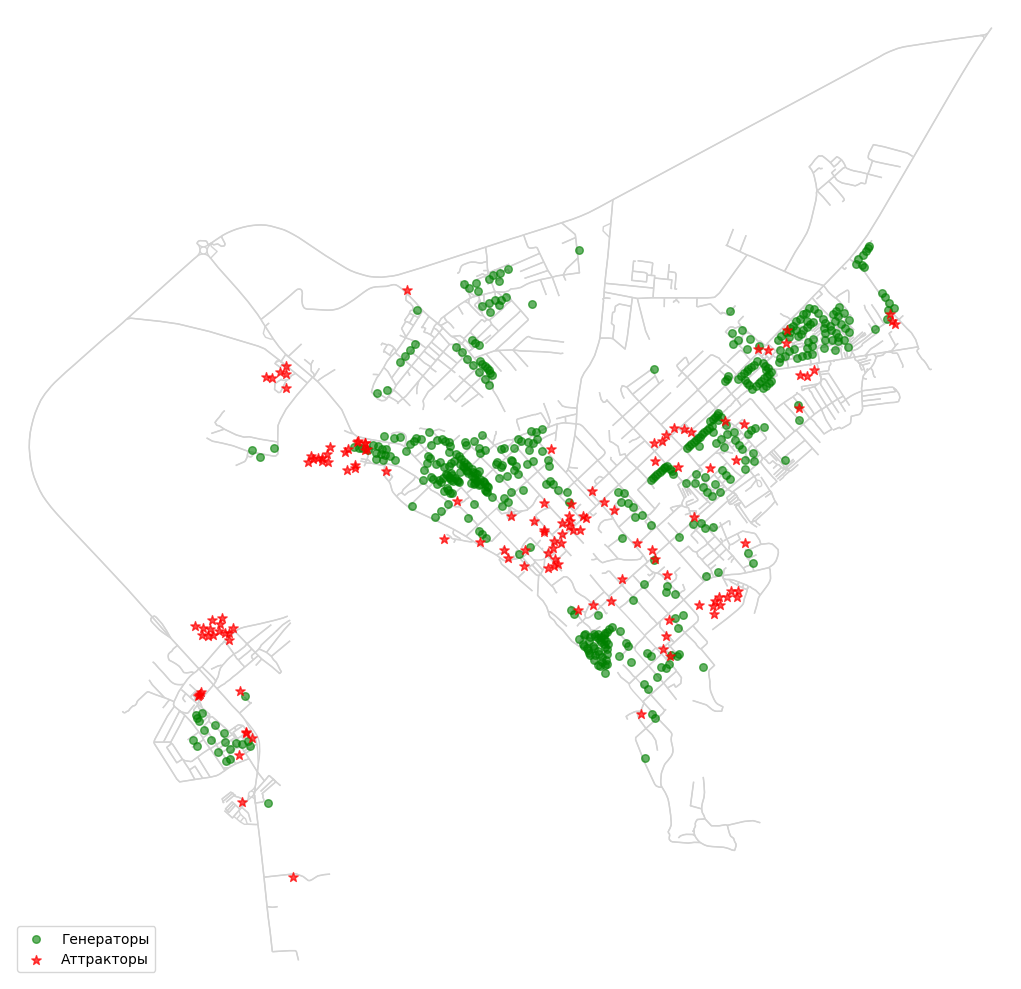

In [64]:
import osmnx as ox
from shapely.geometry import Point
from collections import defaultdict
import geopandas as gpd

class TrafficAttractorAnalyzer:
    def __init__(self, city_name, zone_assignments, num_zones, graph):
        self.city_name = city_name
        self.zone_assignments = zone_assignments
        self.num_zones = num_zones
        self.graph = graph

        self.generators = defaultdict(list)
        self.attractors = defaultdict(list)

    def _get_zone_by_node(self, node_id):
        return self.zone_assignments.get(node_id)

    def _nearest_node_zone(self, point: Point):
        nearest_node = ox.distance.nearest_nodes(self.graph, X=point.x, Y=point.y)
        return self._get_zone_by_node(nearest_node)

    def extract_pois(self):
        tags = {
            "amenity": ["bus_station", "school", "music_school", "college", "university", "kindergarten", "bar", "cafe", "fast_food", 
                        "restaurant", "clinic", "hospital", "community_centre", "ferry_terminal", "food_court", "training", "dentist",
                        "nursing_home", "veterinary", "cinema", "theatre", "library", "pharmacy", "bank", "post_office",
                        "marketplace", "nightclub"],
            "building": ["residential", "apartments", "house", "cabin", "detached", "semidetached_house", "bungalow", "farm", 
                         "terrace", "hotel", "industrial", "office", "supermarket", "mosque", "church", "synagogue", "temple"]
        }

        # gdf = ox.features.features_from_place(self.city_name, tags)

        lat = 54.937289
        lon = 41.391369
        gdf = ox.features.features_from_point((lat, lon), tags, dist=3000)

        print(f"Загружено POI объектов: {len(gdf)}")

        # Преобразуем полигоны в центроиды
        gdf = gdf.copy()
        gdf["geometry"] = gdf.geometry.apply(lambda geom: geom.centroid if geom.geom_type != "Point" else geom)

        for idx, row in gdf.iterrows():
            point = row.geometry
            zone = self._nearest_node_zone(point)
            if zone is None:
                continue

            if row.get("amenity") in ["bus_station", "school", "music_school", "college", "university", "kindergarten", "bar", "cafe",
                                      "fast_food", "restaurant", "clinic", "hospital", "community_centre", "ferry_terminal",
                                      "food_court", "training", "dentist", "nursing_home", "veterinary", "cinema", "theatre", 
                                      "library", "pharmacy", "bank", "post_office", "marketplace", "nightclub"] \
                                        or row.get("building") in ["industrial", "office", "supermarket", "mosque", "church", "synagogue", "temple"]:
                self.attractors[zone].append(row)
            elif row.get("building") in ["residential", "apartments", "house", "cabin", "detached",
                                         "semidetached_house", "bungalow", "farm", "terrace", "hotel"]:
                self.generators[zone].append(row)
    
    def list_poi_names(self):
        print("\nСписок аттракторов и генераторов по зонам:\n")
        for z in range(self.num_zones):
            print(f"--- Зона {z} ---")
            
            print("  Аттракторы:")
            if self.attractors[z]:
                for poi in self.attractors[z]:
                    name = poi.get("name", "(без названия)")
                    category = poi.get("amenity", "N/A")
                    print(f"    - {name} ({category})")
            else:
                print("    (нет аттракторов)")
            
            print("  Генераторы:")
            if self.generators[z]:
                for poi in self.generators[z]:
                    name = poi.get("name", "(без названия)")
                    category = poi.get("building", "N/A")
                    print(f"    - {name} ({category})")
            else:
                print("    (нет генераторов)")

    def summary(self):
        for z in range(self.num_zones):
            print(f"Зона {z}: Генераторов — {len(self.generators[z])}, Аттракторов — {len(self.attractors[z])}")

    def plot_attractors_generators(self):
        fig, ax = plt.subplots(figsize=(12, 10))

        # Фон: транспортный граф
        ox.plot_graph(self.graph, ax=ax, show=False, close=False, edge_color="lightgray", node_size=0)

        # Цвета и стили
        color_map = {
            "generator": "green",
            "attractor": "red"
        }

        # Отображение генераторов
        for zone_id, rows in self.generators.items():
            points = [row.geometry for row in rows if row.geometry.geom_type == "Point"]
            xs, ys = zip(*[(pt.x, pt.y) for pt in points]) if points else ([], [])
            ax.scatter(xs, ys, c=color_map["generator"], s=30, label="Генераторы" if zone_id == 0 else "", alpha=0.6)

        # Отображение аттракторов
        for zone_id, rows in self.attractors.items():
            points = [row.geometry for row in rows if row.geometry.geom_type == "Point"]
            xs, ys = zip(*[(pt.x, pt.y) for pt in points]) if points else ([], [])
            ax.scatter(xs, ys, c=color_map["attractor"], s=50, marker="*", label="Аттракторы" if zone_id == 0 else "", alpha=0.7)

        # Подписи и оформление
        #ax.set_title("Распределение генераторов и аттракторов по зонам", fontsize=14)
        ax.axis("off")
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc="lower left")

        plt.tight_layout()
        plt.show()


attractor_analyzer = TrafficAttractorAnalyzer(
    city_name="Касимов, Россия",
    zone_assignments=zoning.zone_assignments,
    num_zones=zoning.num_zones,
    graph=kasimov.graph
)

attractor_analyzer.extract_pois()
attractor_analyzer.summary()
attractor_analyzer.list_poi_names()
attractor_analyzer.plot_attractors_generators()

In [65]:
# Добавим travel_time к каждому ребру
def add_edge_travel_time(G, default_speed_kph=50):
    for u, v, k, data in G.edges(keys=True, data=True):
        length_m = data.get("length", 0)
        speed_kph = data.get("maxspeed", default_speed_kph)
        if isinstance(speed_kph, list):  # если maxspeed это список
            speed_kph = float(speed_kph[0])
        try:
            speed_mps = float(speed_kph) * 1000 / 3600
        except:
            speed_mps = default_speed_kph * 1000 / 3600
        data["travel_time"] = length_m / speed_mps if speed_mps else 0
    return G

# Применяем к графу
kasimov.graph = add_edge_travel_time(kasimov.graph)

/var/folders/tl/cdz98rwx5p99ltq4d4cbpk2c0000gn/T/ipykernel_22624/1101955486.py:101: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zone_centroids = zoning.gdf_districts.set_index("zone_id").centroid.to_dict()


Балансировка: сумма генераторов (499.0) ≠ сумма аттракторов (135.0)
Сошлось за 5 итераций


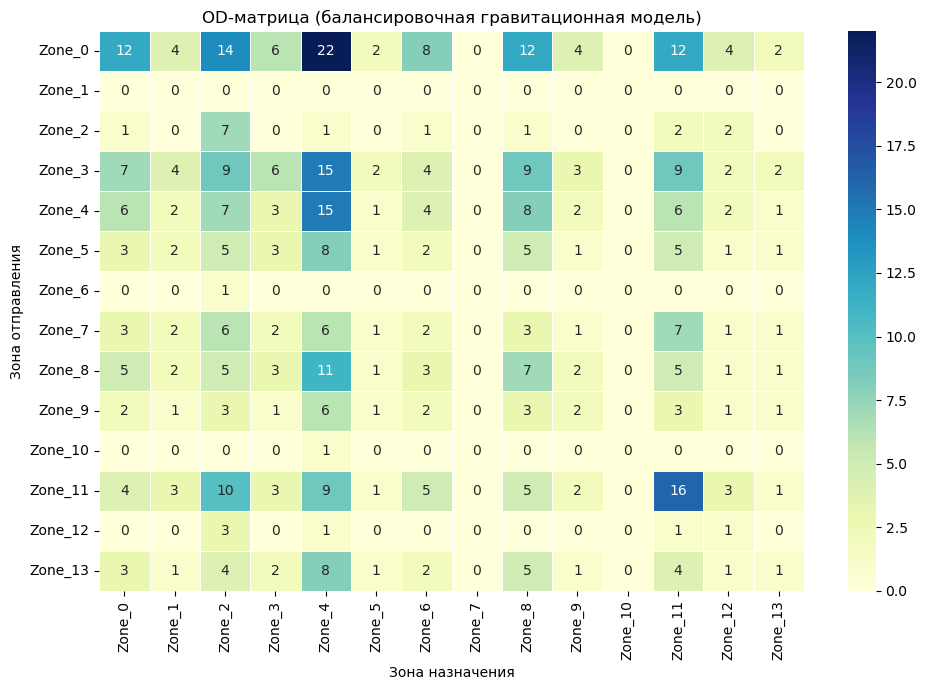

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from shapely.geometry import Point
import osmnx as ox


def build_balanced_gravity_od_matrix(analyzer, zone_centroids, graph, gamma=0.1, theta=1.0, max_iter=1000, tol=1e-5):
    num_zones = analyzer.num_zones
    G = np.array([len(analyzer.generators[i]) for i in range(num_zones)], dtype=float)
    A = np.array([len(analyzer.attractors[j]) for j in range(num_zones)], dtype=float)

    if G.sum() == 0 or A.sum() == 0:
        print("Недостаточно генераторов или аттракторов.")
        return None

    # Балансировка G и A, если суммы не совпадают
    total_G, total_A = G.sum(), A.sum()
    if not np.isclose(total_G, total_A):
        print(f"Балансировка: сумма генераторов ({total_G}) ≠ сумма аттракторов ({total_A})")
        scale_factor = total_G / total_A
        A *= scale_factor

    # Определяем ближайшие узлы к центрам зон
    zone_nodes = {
        i: ox.distance.nearest_nodes(graph, zone_centroids[i].x, zone_centroids[i].y)
        for i in range(num_zones)
    }

    # Строим матрицу затрат c_ij = время в пути в минутах
    C = np.full((num_zones, num_zones), np.inf)
    for i in range(num_zones):
        source = zone_nodes[i]
        lengths = nx.single_source_dijkstra_path_length(graph, source, weight="travel_time")
        for j in range(num_zones):
            target = zone_nodes[j]
            if target in lengths:
                C[i, j] = lengths[target] / 60  # минуты

    # Функция тяготения f(c_ij) = exp(-gamma * c_ij^theta)
    with np.errstate(over='ignore'):
        F = np.exp(-gamma * np.power(C, theta))
    F[np.isinf(C)] = 0  # если нет пути — 0

    # Инициализируем alpha и beta
    alpha = np.ones(num_zones)
    beta = np.ones(num_zones)

    # Итеративная процедура Шацкого—Шелейховского
    for iteration in range(max_iter):
        alpha_prev, beta_prev = alpha.copy(), beta.copy()

        # Обновляем alpha_i
        for i in range(num_zones):
            denom = np.sum(beta * A * F[i, :])
            alpha[i] = 1 / denom if denom > 0 else 0

        # Обновляем beta_j
        for j in range(num_zones):
            denom = np.sum(alpha * G * F[:, j])
            beta[j] = 1 / denom if denom > 0 else 0

        # Проверка сходимости
        delta_alpha = np.linalg.norm(alpha - alpha_prev)
        delta_beta = np.linalg.norm(beta - beta_prev)
        if delta_alpha < tol and delta_beta < tol:
            print(f"Сошлось за {iteration + 1} итераций")
            break
    else:
        print("Не сошлось за максимальное число итераций")

    # Финальный расчёт T_ij
    T = np.zeros((num_zones, num_zones))
    for i in range(num_zones):
        for j in range(num_zones):
            T[i, j] = alpha[i] * beta[j] * G[i] * A[j] * F[i, j]

    # Округлённая матрица для визуализации
    T_int = np.rint(T).astype(int)

    df = pd.DataFrame(
        T_int, columns=[f"Zone_{j}" for j in range(num_zones)],
                 index=[f"Zone_{i}" for i in range(num_zones)]
    )

    # Визуализация
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
    plt.title("OD-матрица (балансировочная гравитационная модель)")
    plt.xlabel("Зона назначения")
    plt.ylabel("Зона отправления")
    plt.tight_layout()
    plt.show()

    return df


# Центроиды зон
zone_centroids = zoning.gdf_districts.set_index("zone_id").centroid.to_dict()

# Расчёт сбалансированной OD-матрицы
od_matrix_balanced = build_balanced_gravity_od_matrix(
    analyzer=attractor_analyzer,
    zone_centroids=zone_centroids,
    graph=kasimov.graph,
    gamma=0.1,
    theta=1.0
)

In [67]:
import pandas as pd
from typing import Optional


class TransportDataAnalyzer:
    def __init__(self):
        self.bus_schedule_df: Optional[pd.DataFrame] = None
        self.passenger_counts_df: Optional[pd.DataFrame] = None
        self.city_entry_exit_df: Optional[pd.DataFrame] = None
        self.pedestrian_flow_df: Optional[pd.DataFrame] = None

    def load_bus_schedule(self, filepath: str):
        self.bus_schedule_df = pd.read_csv(filepath)
        print("Загружено расписание автобусов:", self.bus_schedule_df.shape)

    def load_passenger_counts(self, filepath: str):
        self.passenger_counts_df = pd.read_csv(filepath)
        print("Загружено количество пассажиров:", self.passenger_counts_df.shape)

    def load_entry_exit_data(self, filepath: str):
        self.city_entry_exit_df = pd.read_csv(filepath)
        print("Загружены въезды/выезды в город:", self.city_entry_exit_df.shape)

    def load_pedestrian_flows(self, filepath: str):
        self.pedestrian_flow_df = pd.read_csv(filepath)
        print("Загружены пешие потоки:", self.pedestrian_flow_df.shape)

    # Анализ автобусного расписания
    def analyze_bus_schedule(self):
        if self.bus_schedule_df is None:
            print("Нет данных о расписании.")
            return

        daily_counts = self.bus_schedule_df.groupby("route_id").size()
        print("Количество рейсов по маршрутам:\n", daily_counts)

        plt.figure(figsize=(10, 5))
        daily_counts.sort_values(ascending=False).plot(kind='bar')
        plt.title("Количество рейсов в день по маршрутам")
        plt.xlabel("Маршрут")
        plt.ylabel("Кол-во рейсов")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Анализ пассажиропотоков
    def analyze_passenger_peaks(self):
        if self.passenger_counts_df is None:
            print("Нет данных по пассажирам.")
            return

        peaks = self.passenger_counts_df.groupby("time_period")["passenger_count"].sum()
        print("Пассажиры по временным зонам:\n", peaks)

        peaks.plot(kind='bar', color='skyblue')
        plt.title("Пиковые часы загрузки")
        plt.xlabel("Время суток")
        plt.ylabel("Число пассажиров")
        plt.tight_layout()
        plt.show()

    # ---------------------------
    # 4. Въезды/выезды
    # ---------------------------
    def analyze_entry_exit(self):
        if self.city_entry_exit_df is None:
            print("Нет данных по въезду/выезду.")
            return

        entry = self.city_entry_exit_df.groupby("direction")["count"].sum()
        print("Движение транспорта на въездах/выездах:\n", entry)

        entry.plot(kind='pie', autopct='%1.1f%%', startangle=90)
        plt.title("Доли въезда/выезда в город")
        plt.ylabel("")
        plt.show()

    # ---------------------------
    # 5. Пешие потоки
    # ---------------------------
    def analyze_pedestrian_flows(self):
        if self.pedestrian_flow_df is None:
            print("Нет данных о пешеходах.")
            return

        plt.figure(figsize=(8, 4))
        self.pedestrian_flow_df.groupby("direction")["count"].sum().plot(kind='bar', color='orange')
        plt.title("Пешие потоки от/к вокзалу")
        plt.xlabel("Направление")
        plt.ylabel("Число людей")
        plt.grid(True)
        plt.tight_layout()
        plt.show()